In [1]:
#export
"""
.. module:: k1lib
"""
from typing import Callable, Iterator, Tuple, Union, Dict, Any, List
from k1lib import isNumeric; import k1lib, contextlib, warnings, random
import random, math, sys, io, os, numpy as np, functools, time, traceback, threading, struct
plt = k1lib.dep.plt
try: import torch; hasTorch = True
except: hasTorch = False
__all__ = ["Object", "Range", "Domain", "AutoIncrement", "ConfinedAutoIncrement", "Wrapper", "Every",
           "RunOnce", "MaxDepth", "MovingAvg", "Absorber",
           "Settings", "settings", "_settings", "UValue", "ConstantPad", "AutoUpdateValue", "Aggregate", "Perlin", "Struct"]

In [2]:
#export
class Object:
    """Convenience class that acts like :class:`~collections.defaultdict`. You
can use it like a normal object::

    a = k1lib.Object()
    a.b = 3
    print(a.b) # outputs "3"

``__repr__()`` output is pretty nice too:

.. code-block:: text

    <class '__main__.Object'>, with attrs:
    - b

You can instantiate it from a dict::

    a = k1lib.Object.fromDict({"b": 3, "c": 4})
    print(a.c) # outputs "4"

And you can specify a default value, just like defaultdict::

    a = k1lib.Object().withAutoDeclare(lambda: [])
    a.texts.extend(["factorio", "world of warcraft"])
    print(a.texts[0]) # outputs "factorio"
    
.. warning::

    Default values only work with variables that don't start with an
    underscore "_".

Treating it like defaultdict is okay too::

    a = k1lib.Object().withAutoDeclare(lambda: [])
    a["movies"].append("dune")
    print(a.movies[0]) # outputs "dune" """
    def __init__(self): self._defaultValueGenerator = None; self.repr = None
    @staticmethod
    def fromDict(_dict:Dict[str, Any]):
        """Creates an object with attributes from a dictionary"""
        answer = Object(); answer.__dict__.update(_dict); return answer
    @property
    def state(self) -> dict:
        """Essentially ``__dict__``, but only outputs the fields you
defined. If your framework intentionally set some attributes, those
will be reported too, so beware"""
        answer = dict(self.__dict__); del answer["_defaultValueGenerator"]
        del answer["repr"]; return answer
    def withAutoDeclare(self, defaultValueGenerator):
        """Sets this Object up so that if a field doesn't
        exist, it will automatically create it with a
        default value."""
        self._defaultValueGenerator = defaultValueGenerator; return self
    def __getitem__(self, idx): return getattr(self, idx)
    def __setitem__(self, idx, value): setattr(self, idx, value)
    def __iter__(self): yield from self.state.values()
    def __contains__(self, item:str): return item in self.__dict__
    def __getattr__(self, attr):
        if attr.startswith("_"): raise AttributeError()
        if attr == "getdoc": raise AttributeError("This param is used internally in module `IPython.core.oinspect`, so you kinda have to set it specifically yourself instead of relying on auto declare")
        if self._defaultValueGenerator != None:
            self.__dict__[attr] = self._defaultValueGenerator()
            return self.__dict__[attr]
        raise AttributeError
    def __delitem__(self, key): del self.__dict__[key]
    def withRepr(self, _repr:str):
        """Specify output of ``__repr__()``. Legacy code. You can just
monkey patch it instead."""
        self.repr = _repr; return self
    def __repr__(self):
        _dict = "\n".join([f"- {k}" for k in self.state.keys()])
        return self.repr or f"{type(self)}, with attrs:\n{_dict}"

In [3]:
a = Object().withAutoDeclare(lambda: 0)
a.mins += 10; a.mins += 3; assert a.mins == 13; assert a["mins"] == 13
a["maxs"] += 2; a.maxs += 36; assert a.maxs == 38; assert a["maxs"] == 38
assert a.state == {"mins": 13, "maxs": 38}
del a["mins"]; assert a.state == {"maxs": 38}

In [4]:
#export
ninf = float("-inf"); inf = float("inf")
class Range:
    """A range of numbers. It's just 2 numbers really: start and stop

This is essentially a convenience class to provide a nice, clean
abstraction and to eliminate errors. You can transform values::

    Range(10, 20).toUnit(13) # returns 0.3
    Range(10, 20).fromUnit(0.3) # returns 13
    Range(10, 20).toRange(Range(20, 10), 13) # returns 17

You can also do random math operations on it::

    (Range(10, 20) * 2 + 3) == Range(23, 43) # returns True
    Range(10, 20) == ~Range(20, 10) # returns True"""
    def __init__(self, start=0, stop=None):
        """Creates a new Range.

There are different ``__init__`` functions for many situations:

- Range(2, 11.1): create range [2, 11.1]
- Range(15.2): creates range [0, 15.2]
- Range(Range(2, 3)): create range [2, 3]. This serves as sort of a catch-all
- Range(slice(2, 5, 2)): creates range [2, 5]. Can also be a :class:`range`
- Range(slice(2, -1), 10): creates range [2, 9]
- Range([1, 2, 7, 5]): creates range [1, 5]. Can also be a tuple
"""
        if (isNumeric(start) and isNumeric(stop)):
            self.start, self.stop = start, stop
        elif isNumeric(start) and stop == None:
            self.start, self.stop = 0, start
        elif stop == None and isinstance(start, (range, slice, Range)):
            self.start, self.stop = start.start, start.stop
        elif isNumeric(stop) and isinstance(start, slice):
            r = range(stop)[start]; self.start, self.stop = r.start, r.stop
        elif isinstance(start, (list, tuple)):
            self.start, self.stop = start[0], start[-1]
        else: raise AttributeError(f"Don't understand {start} and {stop}")
        self.delta = self.stop - self.start
    def __getitem__(self, index):
        """0 for start, 1 for stop

You can also pass in a :class:`slice` object, in which case, a range subset
will be returned. Code kinda looks like this::

    range(start, stop)[index]"""
        if index == 0: return self.start
        if index == 1: return self.stop
        if type(index) == slice:
            return Range(range(self.start, self.stop)[index])
        raise Exception(f"Can't get index {index} of range [{self.start}, {self.stop}]")
    def fixOrder(self) -> "Range":
        """If start greater than stop, switch the 2, else do nothing"""
        if self.start > self.stop:
            self.start, self.stop = self.stop, self.start
        return self
    def _common(self, x, f:Callable[[float], float]):
        if isNumeric(x): return f(x)
        if isinstance(x, (list, tuple)):
            return [self._common(elem, f) for elem in x]
        if isinstance(x, (range, slice, Range)):
            return Range(self._common(x.start if x.start != None else 0, f), self._common(x.stop if x.stop != None else 1, f))
        raise AttributeError(f"Doesn't understand {x}")
    def __iter__(self): yield self.start; yield self.stop
    def intIter(self, step:int=1) -> Iterator[int]:
        """Returns integers within this Range"""
        return range(int(self.start), int(self.stop), step)
    def toUnit(self, x):
        """Converts x from current range to [0, 1] range. Example::

    r = Range(2, 10)
    r.toUnit(5) # will return 0.375, as that is (5-2)/(10-2)

You can actually pass in a lot in place of x::

    r = Range(0, 10)
    r.toUnit([5, 3, 6]) # will be [0.5, 0.3, 0.6]. Can also be a tuple
    r.toUnit(slice(5, 6)) # will be slice(0.5, 0.6). Can also be a range, or Range

.. note::

    In the last case, if ``start`` is None, it gets defaulted to 0, and
    if ``end`` is None, it gets defaulted to 1
"""
        def f(x):
            if self.delta == 0: return float("nan")
            return (x - self.start) / self.delta
        return self._common(x, lambda x: float("nan") if self.delta == 0 else (x - self.start) / self.delta)
    def fromUnit(self, x):
        """Converts x from [0, 1] range to this range. Example::

    r = Range(0, 10)
    r.fromUnit(0.3) # will return 3

x can be a lot of things, see :meth:`toUnit` for more"""
        return self._common(x, lambda x: x * self.delta + self.start)
    def toRange(self, _range:"Range", x):
        """Converts x from current range to another range. Example::

    r = Range(0, 10)
    r.toRange(Range(0, 100), 6) # will return 60

x can be a lot of things, see :meth:`toUnit` for more."""
        return self._common(x, lambda x: Range(_range).fromUnit(self.toUnit(x)))
    def fromRange(self, _range:"Range", x):
        """Reverse of :meth:`toRange`, effectively."""
        return _range.toRange(self, x)
    @property
    def range_(self):
        """Returns a :class:`range` object with start and stop values
rounded off"""
        return range(math.floor(self.start+0.001), math.floor(self.stop+0.001))
    @property
    def slice_(self):
        """Returns a :class:`slice` object with start and stop values
rounded off"""
        return slice(math.floor(self.start+0.001), math.floor(self.stop+0.001))
    @staticmethod
    def proportionalSlice(r1, r2, r1Slice:slice) -> Tuple["Range", "Range"]:
        """Slices r1 and r2 proportionally. Best to explain using an
example. Let's say you have 2 arrays created from a time-dependent
procedure like this::

    a = []; b = []
    for t in range(100):
        if t % 3 == 0: a.append(t)
        if t % 5 == 0: b.append(1 - t)
    len(a), len(b) # returns (34, 20)

a and b are of different lengths, but you want to plot both from 30%
mark to 50% mark (for a, it's elements 10 -> 17, for b it's 6 -> 10),
as they are time-dependent. As you can probably tell, to get the indicies
10, 17, 6, 10 is messy. So, you can do something like this instead::

    r1, r2 = Range.proportionalSlice(Range(len(a)), Range(len(b)), slice(10, 17))

This will return the Ranges [10, 17] and [5.88, 10]

Then, you can plot both of them side by side like this::

    fig, axes = plt.subplots(ncols=2)
    axes[0].plot(r1.range_, a[r1.slice_])
    axes[1].plot(r2.range_, a[r2.slice_])
"""
        r1, r2 = Range(r1), Range(r2)
        ar1 = r1[r1Slice]; ar2 = r1.toRange(r2, ar1)
        return ar1, ar2
    def bound(self, rs:Union[range, slice]) -> Union[range, slice]:
        """If input range|slice's stop and start is missing, then use this
range's start and stop instead."""
        start = rs.start or self.start
        stop = rs.stop or self.stop
        return type(rs)(start, stop)
    def copy(self): return Range(self.start, self.stop)
    def __str__(self): return f"[{self.start}, {self.stop}]"
    def __eq__(self, _range):
        _range = Range(_range)
        return (_range.start == self.start or abs(_range.start - self.start) < 1e-9) and\
            (_range.stop == self.stop or abs(_range.stop - self.stop) < 1e-9)
    def __contains__(self, x:float): return x >= self.start and x < self.stop
    def __neg__(self): return Range(-self.start, -self.stop)
    def __invert__(self): return Range(self.stop, self.start)
    def __add__(self, num): return Range(self.start + num, self.stop + num)
    def __radd__(self, num): return self + num
    def __mul__(self, num): return Range(self.start * num, self.stop * num)
    def __rmul__(self, num): return self * num
    def __truediv__(self, num): return num * (1/num)
    def __rtruediv__(self, num): raise "Doesn't make sense to do this!"
    def __round__(self): return Range(round(self.start), round(self.stop))
    def __ceil__(self): return Range(math.ceil(self.start), math.ceil(self.stop))
    def __floor__(self): return Range(math.floor(self.start), math.floor(self.stop))
    def __repr__(self):
        return f"""A range of numbers: [{self.start}, {self.stop}]. Can do:
- r.toUnit(x): will convert x from range [{self.start}, {self.stop}] to [0, 1]
- r.fromUnit(x): will convert x from range [0, 1] to range [{self.start}, {self.stop}]
- r.toRange([a, b], x): will convert x from range [{self.start}, {self.stop}] to range [a, b]
- r[0], r[1], r.start, r.stop: get start and stop values of range

Note: for conversion methods, you can pass in"""

In [5]:
assert Range(range(5)) == Range(0, 5)
# conversions
assert Range(-2, 2).toUnit(0) == 0.5
assert Range(10).toUnit([5, 7]) == [0.5, 0.7]
assert Range(10).toUnit(slice(5, 7)) == Range(0.5, 0.7)
assert Range(10).fromUnit(slice(0.7)) == Range(0, 7)
assert Range(10).toRange([0, 100], [5, 7]) == [50, 70]
assert Range(10).fromUnit(slice(0.2, 0.5)).range_ == range(2, 5)
# __iter__
assert list(range(-5, 100)[Range(3).slice_]) == [-5, -4, -3]
assert list(Range(5).range_) == [0, 1, 2, 3, 4]
# proportionalSlice
a, b = Range.proportionalSlice(Range(10), Range(100), slice(2, 5))
assert a.range_ == range(2, 5); assert b.range_ == range(20, 50)
assert [*Range(2, 5)] == [2, 5]
# __contains__
assert not 1.99 in Range(2, 5); assert not 5 in Range(2, 5)
assert 2 in Range(2, 5); assert 4.99 in Range(2, 5)
# incomplete slice
assert Range(slice(0, -3), 10).range_ == range(0, 7)

In [6]:
#export
def yieldLowest(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Given 2 :class:`Range` generators with lengths a and b, yield every
object (a + b) so that :class:`Range`s with smaller start point gets yielded
first. Assumes that each generator:

- Does not intersect with itself
- Is sorted by start point already

.. warning::

    This method will sometimes yield the same objects given by the Iterators.
    Make sure you copy each :class:`Range` if your use case requires"""
    r1s = iter(r1s); r2s = iter(r2s)
    r1 = next(r1s, None)
    if r1 is None: yield from r2s; return
    r2 = next(r2s, None)
    if r2 is None: yield r1; yield from r1s; return
    while True:
        while r1.start <= r2.start:
            yield r1
            r1 = next(r1s, None)
            if r1 is None: yield r2; yield from r2s; return
        while r2.start <= r1.start:
            yield r2
            r2 = next(r2s, None)
            if r2 is None: yield r1; yield from r1s; return
def join(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Joins 2 :class:`Range` generators, so that overlaps gets merged
together.

.. warning::

    This method will sometimes yield the same objects given by the Iterators.
    Make sure you copy each :class:`Range` if your use case requires"""
    it = yieldLowest(r1s, r2s); r = next(it, None)
    if r is None: return
    while True:
        nr = next(it, None)
        if nr is None: yield r; return
        if r.stop >= nr.start:
            r = r.copy(); r.stop = max(r.stop, nr.stop)
        else: yield r; r = nr
def intersect(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Intersects 2 :class:`Range` generators, so that it only
returns overlaping regions"""
    r1s = iter(r1s); r2s = iter(r2s)
    r1 = next(r1s, None)
    if r1 is None: return
    r2 = next(r2s, None)
    if r2 is None: return
    while True:
        if True: # doesn't intersect at all
            a = max(r1.start, r2.start)
            b = min(r1.stop, r2.stop)
            if a < b: yield Range(a, b)
            if r1.stop > r2.stop: # loads next r2
                r2 = next(r2s, None)
                if r2 is None: return
            else: # loads next r1
                r1 = next(r1s, None)
                if r1 is None: return

In [7]:
a = [Range(2, 3), Range(10, 13)]; b = [Range(-5, 0), Range(4, 9)] # don't overlap
c = [Range(-1, 2.5)]; d = [Range(5, 11)] # overlap before, after
e = [Range(2.5, 11)] # overlap covers gap entirely
f = [Range(-1, 15)] # covers everything
assert list(yieldLowest(a, [])) == a; assert list(yieldLowest([], a)) == a
assert list(join(a, [])) == a; assert list(join([], a)) == a
assert list(join(a, c)) == [Range(-1, 3), Range(10, 13)]
assert list(join(a, d)) == [Range(2, 3), Range(5, 13)]
assert list(join(a, e)) == [Range(2, 13)]
assert list(join(a, f)) == [Range(-1, 15)]
assert list(intersect(a, b)) == []
assert list(intersect(a, c)) == [Range(2, 2.5)]

In [8]:
#export
def neg(rs:List[Range]):
    """Returns R - rs, where R is the set of real numbers."""
    rs = iter(rs); r = next(rs, None)
    if r is None: yield Range(ninf, inf); return
    if ninf < r.start: yield Range(ninf, r.start) # check -inf case
    while True:
        start = r.stop
        r = next(rs, None)
        if r is None:
            if start < inf: yield Range(start, inf)
            return
        yield Range(start, r.start)

In [9]:
assert list(neg([Range(ninf, 3), Range(5, 6)])) == [[3, 5], [6, inf]]
assert list(neg([Range(2, 3), Range(5, 6)])) == [[ninf, 2], [3, 5], [6, inf]]
assert list(neg([Range(2, 3), Range(5, inf)])) == [[ninf, 2], [3, 5]]

In [10]:
#export
class Domain:
    def __init__(self, *ranges, dontCheck:bool=False):
        """Creates a new domain.

:param ranges: each element is a :class:`Range`, although any format will be fine as this selects for that
:param dontCheck: don't sanitize inputs, intended to boost perf internally only

A domain is just an array of :class:`Range` that represents what intervals on
the real number line is chosen. Some examples::

    inf = float("inf") # shorthand for infinity
    Domain([5, 7.5], [2, 3]) # represents "[2, 3) U [5, 7.5)"
    Domain([2, 3.2], [3, 8]) # represents "[2, 8)" as overlaps are merged
    -Domain([2, 3]) # represents "(-inf, 2) U [3, inf)", so essentially R - d, with R being the set of real numbers
    -Domain([-inf, 3]) # represents "[3, inf)"
    Domain.fromInts(2, 3, 6) # represents "[2, 4) U [6, 7)"

You can also do arithmetic on them, and check "in" oeprator::

    Domain([2, 3]) + Domain([4, 5]) # represents "[2, 3) U [4, 5)"
    Domain([2, 3]) + Domain([2.9, 5]) # represents "[2, 5)", also merges overlaps
    Domain([2, 3]) & Domain([2.5, 5]) # represents "[2, 3) A [2.5, 5)", or "[2.5, 3)"
    3 in Domain([2, 3]) # returns False
    2 in Domain([2, 3]) # returns True"""
        if dontCheck: self.ranges = list(ranges); return
        # convert all to Range type, fix its order, and sort based on .start
        ranges = [(r if isinstance(r, Range) else Range(r)).fixOrder() for r in ranges]
        ranges = sorted(ranges, key=lambda r: r.start)
        # merges overlapping segments
        self.ranges = list(join(ranges, []))
    @staticmethod
    def fromInts(*ints:List[int]):
        """Returns a new :class:`Domain` which has ranges [i, i+1] for each
int given."""
        return Domain(*(Range(i, i+1) for i in ints))
    def copy(self): return Domain(*(r.copy() for r in self.ranges))
    def intIter(self, step:int=1, start:int=0):
        """Yields ints in all ranges of this domain. If first range's domain
is :math:`(-\\inf, a)`, then starts at the specified integer"""
        if len(self.ranges) == 0: return
        for r in self.ranges:
            x = int(start) if r.start == -inf else int(r.start)
            while x < r.stop: yield x; x += step
    def __neg__(self): return Domain(*neg(self.ranges), dontCheck=True)
    def __add__(self, domain): return Domain(*(r.copy() for r in join(self.ranges, domain.ranges)), dontCheck=True)
    def __sub__(self, domain): return self + (-domain)
    def __and__(self, domain): return Domain(*intersect(self.ranges, domain.ranges), dontCheck=True)
    def __eq__(self, domain): return self.ranges == domain.ranges
    def __str__(self): return f"Domain: {', '.join(str(r) for r in self.ranges)}"
    def __contains__(self, x): return any(x in r for r in self.ranges)
    def __repr__(self):
        rs = '\n'.join(f"- {r}" for r in self.ranges)
        return f"""Domain:\n{rs}\n\nCan:
- 3 in d: check whether a number is in this domain or not
- d1 + d2: joins 2 domains
- -d: excludes the domain from R
- d1 - d2: same as d1 + (-d2)
- d1 & d2: intersects 2 domains"""

In [11]:
assert -(-Domain([2, 3])) == Domain([2, 3])
assert -Domain([2, 3]) == Domain([ninf, 2], [3, inf])
assert -Domain([2, 3], [5, 10]) == Domain([ninf, 2], [3, 5], [10, inf])
Domain([2, 3]).copy(); # just test copying
assert list(Domain([2, 8]).intIter()) == [2, 3, 4, 5, 6, 7]
assert Domain([2, 3]) & Domain([2.5, 5]) == Domain([2.5, 3])
assert Domain([0, 100]) & Domain([-100, 10], [20, 30], [40, 50]) == Domain([0, 10], [20, 30], [40, 50])

In [12]:
#export
puas = [[ord(c) for c in cs] for cs in [["\ue000", "\uf8ff"], ["\U000f0000", "\U000ffffd"], ["\U00100000", "\U0010fffd"]]]
class AutoIncrement:
    def __init__(self, initialValue:int=-1, n:int=float("inf"), prefix:str=None):
        """Creates a new AutoIncrement object. Every time the object is called
it gets incremented by 1 automatically. Example::

    a = k1lib.AutoIncrement()
    a() # returns 0
    a() # returns 1
    a() # returns 2
    a.value # returns 2
    a.value # returns 2
    a() # returns 3

    a = AutoIncrement(n=3, prefix="cluster_")
    a() # returns "cluster_0"
    a() # returns "cluster_1"
    a() # returns "cluster_2"
    a() # returns "cluster_0"

:param n: if specified, then will wrap around to 0 when hit this number
:param prefix: if specified, will yield strings with specified prefix"""
        self.value = initialValue; self.n = n; self.prefix = prefix
    @staticmethod
    def random() -> "AutoIncrement":
        """Creates a new AutoIncrement object that has a random integer initial value"""
        return AutoIncrement(random.randint(0, int(1e9)))
    @property
    def value(self):
        """Get the value as-is, without auto incrementing it"""
        if self.prefix is None: return self._value
        return f"{self.prefix}{self._value}"
    @value.setter
    def value(self, value): self._value = value
    def __call__(self):
        """Increments internal counter, and return it."""
        self._value += 1
        if self._value >= self.n: self._value = 0
        return self.value
    @staticmethod
    def unicode_pua():
        """Returns a generator that generates unicode characters from within
unicode's private use area (PUA). Example::

    a = k1.AutoIncrement.unicode_pua()
    a | head() | deref() # returns ['\ue000', '\ue001', '\ue002', '\ue003', '\ue004', '\ue005', '\ue006', '\ue007', '\ue008', '\ue009']
"""
        for pua in puas:
            for c in range(pua[0], pua[1]+1): yield chr(c)

In [13]:
a = AutoIncrement(); a.value = 10; assert a() == 11
a = AutoIncrement(n=3, prefix="cluster_")
assert a() == "cluster_0"; assert a() == "cluster_1"
assert a() == "cluster_2"; assert a() == "cluster_0"
assert [x for x,y in zip(AutoIncrement.unicode_pua(), range(10))] == ['\ue000', '\ue001', '\ue002', '\ue003', '\ue004', '\ue005', '\ue006', '\ue007', '\ue008', '\ue009']

In [52]:
#export
class ConfinedAutoIncrement:
    def __init__(self, maxValue=16):
        """Similar to :class:`AutoIncrement`, but this time the yielded numbers
become cyclical, and in [0, maxValue). The applications for this class is
rather niche, as I need it only for a hardware project that require strict id
generation::

    a = ConfinedAutoIncrement(4)
    a() # returns 1
    a() # returns 2
    a() # returns 3
    a.remove(2)
    a() # returns 0
    a() # returns 2
    a() # throws an error as it ran out of elements to yield

:param maxValue: max value that can be yielded"""
        self.maxValue = maxValue; self.i = 0; self.currentValues = []
    def __call__(self):
        currentValues = self.currentValues; maxValue = self.maxValue; i = self.i
        if len(currentValues) == maxValue: raise Exception("Ran out of elements to yield")
        while True:
            i = (i+1) % maxValue
            if i not in currentValues: currentValues.append(i); self.i = i; return i
    def remove(self, k): self.currentValues.remove(k)
    def __repr__(self): return f"<ConfinedAutoIncrement max={self.maxValue} len={len(self.currentValues)} >"

In [53]:
a = ConfinedAutoIncrement(4); assert a() == 1; assert a() == 2; assert a() == 3; a.remove(2); assert a() == 0; assert a() == 2

In [14]:
#export
class Wrapper:
    value:Any
    """Internal value of this :class:`Wrapper`"""
    def __init__(self, value=None):
        """Creates a wrapper for some value and get it by calling it.
Example::

    a = k1.Wrapper(list(range(int(1e7))))
    # returns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    a()[:10]

This exists just so that Jupyter Lab's contextual help won't automatically
display the (possibly humongous) value. Could be useful if you want to pass a
value by reference everywhere like this::

    o = k1.Wrapper(None)
    def f(obj):
        obj.value = 3
    f(o)
    o() # returns 3

You can also pipe into it like this:

    o = 3 | k1.Wrapper()
    o() # returns 3
"""
        self.value = value
    def __call__(self): return self.value
    def __ror__(self, it): return Wrapper(it)

In [15]:
o = k1lib.Wrapper(None)
def f(obj): obj.value = 3
f(o); assert o() == 3
o = 3 | Wrapper(); assert o() == 3

In [16]:
#export
class Every:
    def __init__(self, n):
        """Returns True every interval.
Example::

    e = k1lib.Every(4)
    e() # returns True
    e() # returns False
    e() # returns False
    e() # returns False
    e() # returns True"""
        self.n = n; self.i = -1
    def __call__(self) -> bool:
        """Returns True or False based on internal count."""
        self.i += 1; return self.value
    @property
    def value(self) -> bool:
        if self.i % self.n: return False
        else: return True

In [17]:
e = Every(4)
assert e(); assert not e(); assert not e()
assert not e(); assert e()

In [18]:
#export
class RunOnce:
    def __init__(self):
        """Returns False first time only.
Example::

    r = k1lib.RunOnce()
    r.done() # returns False
    r.done() # returns True
    r.done() # returns True
    r.revert()
    r.done() # returns False
    r.done() # returns True
    r.done() # returns True

May be useful in situations like::

    class A:
        def __init__(self):
            self.ro = k1lib.RunOnce()
        def f(self, x):
            if self.ro.done(): return 3 + x
            return 5 + x
    a = A()
    a.f(4) # returns 9
    a.f(4) # returns 7"""
        self.value = False
    def done(self):
        """Whether this has been called once before."""
        v = self.value
        self.value = True
        return v
    def __call__(self):
        """Alias of :meth:`done`."""
        return self.done()
    def revert(self):
        self.value = False

In [19]:
r = RunOnce(); assert not r.done(); assert r.done(); assert r.done()
r.revert(); assert not r.done(); assert r.done(); assert r.done()
class A:
    def __init__(self):
        self.ro = RunOnce()
    def f(self, x):
        if self.ro.done(): return 3 + x
        return 5 + x
a = A(); assert a.f(4) == 9; assert a.f(4) == 7

In [20]:
#export
class MaxDepth:
    def __init__(self, maxDepth:int, depth:int=0):
        """Convenience utility to check for graph max depth.
Example::

    def f(d):
        print(d.depth)
        if d: f(d.enter())
    # prints "0\\n1\\n2\\n3"
    f(k1lib.MaxDepth(3))

Of course, this might look unpleasant to the end user, so this is more
likely for internal tools."""
        self.maxDepth = maxDepth; self.depth = depth
    def enter(self) -> "MaxDepth":
        return MaxDepth(self.maxDepth, self.depth + 1)
    def __bool__(self):
        return self.depth < self.maxDepth
    def __call__(self):
        """Alias of :meth:`__bool__`."""
        return bool(self)

In [21]:
def f(d):
    print(d.depth)
    if d: f(d.enter())
with k1lib.captureStdout() as out: f(MaxDepth(3))
assert out() == ['0', '1', '2', '3', '']

In [22]:
#export
class MovingAvg:
    def __init__(self, initV:float=0, alpha=0.9, debias=False):
        """Smoothes out sequential data using momentum.
Example::

    a = k1lib.MovingAvg(5)
    a(3).value # returns 4.8, because 0.9*5 + 0.1*3 = 4.8
    a(3).value # returns 4.62

There's also a cli at :class:`~k1lib.cli.conv.toMovingAvg` that does the exact
same thing, but just more streamlined and cli-like. Both versions are kept as
sometimes I do want a separate object with internal state

Difference between normal and debias modes::

    x = torch.linspace(0, 10, 100); y = torch.cos(x) | op().item().all() | deref()
    plt.plot(x, y);
    a = k1lib.MovingAvg(debias=False); plt.plot(x, y | apply(lambda y: a(y).value) | deref())
    a = k1lib.MovingAvg(debias=True); plt.plot(x, y | apply(lambda y: a(y).value) | deref())
    plt.legend(["Signal", "Normal", "Debiased"])

.. image:: images/movingAvg.png

As you can see, normal mode still has the influence of the initial value at
0 and can't rise up fast, whereas the debias mode will ignore the initial
value and immediately snaps to the first saved value.

:param initV: initial value
:param alpha: number in [0, 1]. Basically how much to keep old value?
:param debias: whether to debias the initial value"""
        self.value = initV; self.alpha = alpha; self.debias = debias
        self.m = self.value; self.t = 0
    def __call__(self, value):
        """Updates the average with a new value"""
        self.m = self.m * self.alpha + value * (1 - self.alpha)
        if self.debias:
            self.t += 1
            self.value = self.m / (1 - self.alpha**self.t)
        else: self.value = self.m
        return self
    def __add__(self, o): return self.value + o
    def __radd__(self, o): return o + self.value
    def __sub__(self, o): return self.value - o
    def __rsub__(self, o): return o - self.value
    def __mul__(self, o): return self.value * o
    def __rmul__(self, o): return o * self.value
    def __truediv__(self, o): return self.value / o
    def __rtruediv__(self, o): return o / self.value
    def __repr__(self):
        return f"Moving average: {self.value}, alpha: {self.alpha}"

In [42]:
#export
sen = "_ab_sentinel"
jitOpcodes = {"__len__": lambda x: f"len({x})",
              "__neg__": lambda x: f"(-{x})",
              "__pos__": lambda x: f"(+{x})",
              "__abs__": lambda x: f"abs({x})",
              "__invert__": lambda x: f"(~{x})",
              "__getattr__": lambda x, idx: f"getattr({x},{idx})",
              "__getitem__": lambda x, idx: f"({x}[{idx}])",
              "__round__": lambda x, o: f"round({x}, {o})",
              "__add__": lambda x, o: f"({x}+{o})",
              "__radd__": lambda x, o: f"({o}+{x})",
              "__sub__": lambda x, o: f"({x}-{o})",
              "__rsub__": lambda x, o: f"({o}-{x})",
              "__mul__": lambda x, o: f"({x}*{o})",
              "__rmul__": lambda x, o: f"({o}*{x})",
              "__matmul__": lambda x, o: f"({x}@{o})",
              "__rmatmul__": lambda x, o: f"({o}@{x})",
              "__truediv__": lambda x, o: f"({x}/{o})",
              "__rtruediv__": lambda x, o: f"({o}/{x})",
              "__floordiv__": lambda x, o: f"({x}//{o})",
              "__rfloordiv__": lambda x, o: f"({o}//{x})",
              "__mod__": lambda x, o: f"({x}%{o})",
              "__rmod__": lambda x, o: f"({o}%{x})",
              "__pow__": lambda x, o: f"({x}**{o})",
              "__rpow__": lambda x, o: f"({o}**{x})",
              "__lshift__": lambda x, o: f"({x}<<{o})",
              "__rlshift__": lambda x, o: f"({o}<<{x})",
              "__rshift__": lambda x, o: f"({x}>>{o})",
              "__rrshift__": lambda x, o: f"({o}>>{x})",
              "__and__": lambda x, o: f"({x}&{o})",
              "__rand__": lambda x, o: f"({o}&{x})",
              "__xor__": lambda x, o: f"({x}^{o})",
              "__rxor__": lambda x, o: f"({o}^{x})",
              "__or__": lambda x, o: f"({x}|{o})",
              "__ror__": lambda x, o: f"({o}|{x})",
              "__lt__": lambda x, o: f"({x}<{o})",
              "__le__": lambda x, o: f"({x}<={o})",
              "__eq__": lambda x, o: f"({x}=={o})",
              "__ne__": lambda x, o: f"({x}!={o})",
              "__gt__": lambda x, o: f"({x}>{o})",
              "__ge__": lambda x, o: f"({x}>={o})",}
opcodeAuto = AutoIncrement(prefix=f"_op_{random.randint(100,999)}_var_")
compareOps = {"__lt__", "__le__", "__eq__", "__ne__", "__gt__", "__ge__"}
class Absorber:
    """Creates an object that absorbes every operation done on it. Could be
useful in some scenarios::

    ab = k1lib.Absorber()
    # absorbs all operations done on the object
    abs(ab[::3].sum(dim=1))

    t = torch.randn(5, 3, 3)
    # returns transformed tensor of size [2, 3]
    ab.ab_operate(t)

Another::

    ab = Absorber()
    ab[2] = -50
    # returns [0, 1, -50, 3, 4]
    ab.ab_operate(list(range(5)))

Because this object absorbs every operation done on it, you have to be gentle with
it, as any unplanned disturbances might throw your code off. Best to create a new
one on the fly, and pass them immediately to functions, because if you're in a
notebook environment like Jupyter, it might poke at variables.

For extended code example that utilizes this, check over :class:`k1lib.cli.modifier.op`
source code."""
    def __init__(self, initDict:dict=dict()):
        """Creates a new Absorber.

:param initDict: initial variables to set, as setattr operation is normally absorbed"""
        self._ab_sentinel = True
        self._ab_steps = []
        self._ab_solidified = False
        for k, v in initDict.items(): setattr(self, k, v)
        self._ab_sentinel = False
    def ab_solidify(self):
        """Use this to not absorb ``__call__`` operations anymore and makes it
feel like a regular function (still absorbs other operations though)::

    f = op()**2
    3 | f # returns 9, but may be you don't want to pipe it in
    f.op_solidify()
    f(3)  # returns 9"""
        self._ab_sentinel = True
        self._ab_solidified = True
        self._ab_sentinel = False
        return self
    def ab_operate(self, x):
        """Special method to actually operate on an object and get the result. Not
absorbed. Example::

    # returns 6
    (op() * 2).ab_operate(3)"""
        for desc, step in self._ab_steps: x = step(x)
        return x
    def ab_fastFS(self) -> str:
        s = self._ab_steps; l = len(s)
        x = k1lib.cli.init._jsDAuto()
        try: # jit compilation
            ss = x; values = {}
            for (opcode, *o), *_ in s:
                if opcode == "__call__":
                    va = opcodeAuto(); hasArgs = len(o[0][0]) > 0; vk = opcodeAuto(); hasKwargs = len(o[0][1]) > 0
                    if hasArgs: values[va] = o[0][0] # if don't have args or kwargs, then don't include it in the compiled expression. This is important for the js transpiler in kjs
                    if hasKwargs: values[vk] = o[0][1]
                    _a = ", ".join([*([f"*{va}"] if hasArgs else []), *([f"**{vk}"] if hasKwargs else [])]); ss = f"({ss}({_a}))"
                elif len(o) > 0:
                    varname = opcodeAuto(); v = o[0]
                    if isinstance(v, (int, float)): ss = jitOpcodes[opcode](ss, v)
                    else: values[varname] = v; ss = jitOpcodes[opcode](ss, varname)
                else: ss = jitOpcodes[opcode](ss)
            return [f"lambda {x}: {ss}", values]
        except Exception as e: pass
    def ab_fastF(self):
        """Returns a function that operates on the input (just like :meth:`ab_operate`),
but much faster, suitable for high performance tasks. Example::

    f = (k1lib.Absorber() * 2).ab_fastF()
    # returns 6
    f(3)"""
        s = self._ab_steps; l = len(s)
        res = self.ab_fastFS() # jit compilation, compressing multiple steps to a single simple expression
        if res: fn, values = res; return eval(compile(fn, "", "eval"), values)
        if l == 0: return lambda x: x
        if l == 1: return s[0][1]
        if l == 2:
            a, b = s[0][1], s[1][1]
            return lambda x: b(a(x))
        if l == 3:
            a, b, c = s[0][1], s[1][1], s[2][1]
            return lambda x: c(b(a(x)))
        if l == 4:
            a, b, c, d = s[0][1], s[1][1], s[2][1], s[3][1]
            return lambda x: d(c(b(a(x))))
        if l == 5:
            a, b, c, d, e = s[0][1], s[1][1], s[2][1], s[3][1], s[4][1]
            return lambda x: e(d(c(b(a(x)))))
        return self.ab_operate
    def _ab_steps_append(self, o):
        if not self._ab_solidified:
            s = self._ab_steps
            if len(s) > 0 and s[-1][0][0] in compareOps and o[0][0] in compareOps:
                p = s.pop(); a = p[1]; b = o[1] # for 2 consecutive compare operations
                s.append([["compareOps"], lambda x: a(x) and b(x)])
            else: s.append(o)
        return self
    def __getattr__(self, idx):
        if isinstance(idx, str) and idx.startswith("_"): raise AttributeError("Getting attributes starting with underscore is prohibited. If you're using `op`, consider using `aS(lambda x: x._field)` instead.")
        return self._ab_steps_append([["__getattr__", idx], lambda x: getattr(x, idx)]);
    def __setattr__(self, k, v):
        """Only allows legit variable setting when '_ab_sentinel' is True. Absorbs
operations if it's False."""
        if k == sen: self.__dict__[k] = v
        else:
            if self.__dict__[sen]: self.__dict__[k] = v
            else:
                def f(x): setattr(x, k, v); return x
                self._ab_steps_append([["__setattr__", [k, v]], f])
                if self._ab_solidified: self.__dict__[k] = v
                return self
    def __getitem__(self, idx): return self._ab_steps_append([["__getitem__", idx], lambda x: x[idx]]);
    def __setitem__(self, k, v):
        def f(x): x[k] = v; return x
        return self._ab_steps_append([["__setitem__", [k, v]], f]);
    def __call__(self, *args, **kwargs): return self._ab_steps_append([["__call__", [args, kwargs]], lambda x: x(*args, **kwargs)]);
    def __round__(self, ndigits=0):   return self._ab_steps_append([["__round__",       ndigits], lambda x: round(x, ndigits)]);
    def __add__(self, o):       return self._ab_steps_append([["__add__",       o], lambda x: x+o ]);
    def __radd__(self, o):      return self._ab_steps_append([["__radd__",      o], lambda x: o+x ]);
    def __sub__(self, o):       return self._ab_steps_append([["__sub__",       o], lambda x: x-o ]);
    def __rsub__(self, o):      return self._ab_steps_append([["__rsub__",      o], lambda x: o-x ]);
    def __mul__(self, o):       return self._ab_steps_append([["__mul__",       o], lambda x: x*o ]);
    def __rmul__(self, o):      return self._ab_steps_append([["__rmul__",      o], lambda x: o*x ]);
    def __matmul__(self, o):    return self._ab_steps_append([["__matmul__",    o], lambda x: x@o ]);
    def __rmatmul__(self, o):   return self._ab_steps_append([["__rmatmul__",   o], lambda x: o@x ]);
    def __truediv__(self, o):   return self._ab_steps_append([["__truediv__",   o], lambda x: x/o ]);
    def __rtruediv__(self, o):  return self._ab_steps_append([["__rtruediv__",  o], lambda x: o/x ]);
    def __floordiv__(self, o):  return self._ab_steps_append([["__floordiv__",  o], lambda x: x//o]);
    def __rfloordiv__(self, o): return self._ab_steps_append([["__rfloordiv__", o], lambda x: o//x]);
    def __mod__(self, o):       return self._ab_steps_append([["__mod__",       o], lambda x: x%o ]);
    def __rmod__(self, o):      return self._ab_steps_append([["__rmod__",      o], lambda x: o%x ]);
    def __pow__(self, o):       return self._ab_steps_append([["__pow__",       o], lambda x: x**o]);
    def __rpow__(self, o):      return self._ab_steps_append([["__rpow__",      o], lambda x: o**x]);
    def __lshift__(self, o):    return self._ab_steps_append([["__lshift__",    o], lambda x: x<<o]);
    def __rlshift__(self, o):   return self._ab_steps_append([["__rlshift__",   o], lambda x: o<<x]);
    def __rshift__(self, o):    return self._ab_steps_append([["__rshift__",    o], lambda x: x>>o]);
    def __rrshift__(self, o):   return self._ab_steps_append([["__rrshift__",   o], lambda x: o>>x]);
    def __and__(self, o):       return self._ab_steps_append([["__and__",       o], lambda x: x&o ]);
    def __rand__(self, o):      return self._ab_steps_append([["__rand__",      o], lambda x: o&x ]);
    def __xor__(self, o):       return self._ab_steps_append([["__xor__",       o], lambda x: x^o ]);
    def __rxor__(self, o):      return self._ab_steps_append([["__rxor__",      o], lambda x: o^x ]);
    def __or__(self, o):        return self._ab_steps_append([["__or__",        o], lambda x: x|o ]);
    def __ror__(self, o):       return self._ab_steps_append([["__ror__",       o], lambda x: o|x ]);
    def __lt__(self, o):        return self._ab_steps_append([["__lt__",        o], lambda x: x<o ]);
    def __le__(self, o):        return self._ab_steps_append([["__le__",        o], lambda x: x<=o]);
    def __eq__(self, o):        return self._ab_steps_append([["__eq__",        o], lambda x: x==o]);
    def __ne__(self, o):        return self._ab_steps_append([["__ne__",        o], lambda x: x!=o]);
    def __gt__(self, o):        return self._ab_steps_append([["__gt__",        o], lambda x: x>o ]);
    def __ge__(self, o):        return self._ab_steps_append([["__ge__",        o], lambda x: x>=o]);
    def __neg__(self):    return self._ab_steps_append([["__neg__"],    lambda x: -x      ]);
    def __pos__(self):    return self._ab_steps_append([["__pos__"],    lambda x: +x      ]);
    def __abs__(self):    return self._ab_steps_append([["__abs__"],    lambda x: abs(x)  ]);
    def __invert__(self): return self._ab_steps_append([["__invert__"], lambda x: ~x      ]);
    def ab_int(self):
        """Replacement for ``int(ab)``, as that requires returning an actual :class:`int`."""
        return self._ab_steps_append([["__int__"],    lambda x: int(x)  ]);
    def __int__(self):    return self.int()
    def ab_float(self):
        """Replacement for ``float(ab)``, as that requires returning an actual :class:`float`."""
        return self._ab_steps_append([["__float__"],  lambda x: float(x)]);
    def __float__(self):  return self.float()
    def ab_str(self):
        """Replacement for ``str(ab)``, as that requires returning an actual :class:`str`."""
        return self._ab_steps_append([["__str__"],    lambda x: str(x)  ]);
    def ab_len(self):
        """Replacement for ``len(ab)``, as that requires returning an actual :class:`int`."""
        return self._ab_steps_append([["__len__"],    lambda x: len(x)  ]);
    def ab_contains(self, key):
        """Replacement for ``key in ab``, as that requires returning an actual :class:`int`."""
        return self._ab_steps_append([["__contains__", key], lambda x: key in x]);

In [49]:
ab = abs(Absorber()[::3].sum(dim=1))
assert ab.ab_operate(torch.randn(5, 3, 3)).shape == torch.Size([2, 3])
ab = Absorber(); ab.value = 3
assert ab.ab_operate(AutoIncrement()).value == 3
ab = Absorber(); ab[2] = -50
assert ab.ab_operate(list(range(5))) == [0, 1, -50, 3, 4]
assert (Absorber() * 2).ab_fastF()(3) == 6
assert (Absorber() * 2).ab_operate(3) == 6
assert len((Absorber().value()).ab_fastFS()[1]) == 1

In [39]:
#export
sep = "\u200b" # weird separator, guaranteed (mostly) to not appear anywhere in the
# settings, so that I can pretty print it
class Settings:
    def __init__(self, **kwargs):
        """Creates a new settings object. Basically fancy version of :class:`dict`.
Example::

    s = k1lib.Settings(a=3, b="42")
    s.c = k1lib.Settings(d=8)
    
    s.a # returns 3
    s.b # returns "42"
    s.c.d # returns 8
    print(s) # prints nested settings nicely"""
        self._setattr_sentinel = True
        for k, v in kwargs.items(): setattr(self, k, v)
        self._docs = dict(); self._cbs = dict(); self._sensitives = dict(); self._envs = dict()
        self._setattr_sentinel = False
    @contextlib.contextmanager
    def context(self, **kwargs):
        """Context manager to temporarily modify some settings. Applies
to all sub-settings. Example::

    s = k1lib.Settings(a=3, b="42", c=k1lib.Settings(d=8))
    with s.context(a=4):
        s.c.d = 20
        s.a # returns 4
        s.c.d # returns 20
    s.a # returns 3
    s.c.d # returns 8"""
        oldValues = dict(self.__dict__); err = None
        for k in kwargs.keys():
            if k not in oldValues:
                raise RuntimeError(f"'{k}' settings not found!")
        try:
            with contextlib.ExitStack() as stack:
                for _, sub in self._subSettings():
                    stack.enter_context(sub.context())
                for k, v in kwargs.items(): setattr(self, k, v)
                yield
        finally:
            for k, v in oldValues.items(): setattr(self, k, v)
    def add(self, k:str, v:Any, docs:str="", cb:Callable[["Settings", Any], None]=None, sensitive:bool=False, env:str=None) -> "Settings":
        """Long way to add a variable. Advantage of this is that you can slip in extra
documentation for the variable. Example::

    s = k1lib.Settings()
    s.add("a", 3, "some docs")
    print(s) # displays the extra docs

You can also specify that a variable should load from the environment variables::

    s = k1lib.Settings()
    s.add("a", "/this/path/will:/be/overridden", env="PATH")
    s.a # will returns a string that might look like "/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games"

You can specify a transform function if you want to::

    s = k1lib.Settings()
    s.add("a", ["/this/path/will", "/be/overridden"], env=("PATH", lambda x: x.split(":")))
    s.a # returns a list that might look like ['/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games']

:param cb: callback that takes in (settings, new value) if any property changes
:param sensitive: if True, won't display the value when displaying the whole Settings object
:param env: if specified, will try to load up the value from environment variables if it's available"""
        if env is not None:
            s, f = (env, lambda x: x) if isinstance(env, str) else env; res = os.environ.get(s); self._envs[k] = s
            if res is not None: v = f(res)
        setattr(self, k, v); self._docs[k] = docs; self._cbs[k] = cb
        self._sensitives[k] = sensitive; return self
    def _docsOf(self, k:str): return f"{self._docs[k]}" if k in self._docs else ""
    def _envsOf(self, k:str): return f"env: {self._envs[k]}" if k in self._envs else ""
    def _subSettings(self) -> List[Tuple[str, "Settings"]]:
        return [(k, v) for k, v in self.__dict__.items() if isinstance(v, Settings) and not k.startswith("_")]
    def _simpleSettings(self) -> List[Tuple[str, Any]]:
        return [(k, v) for k, v in self.__dict__.items() if not isinstance(v, Settings) and not k.startswith("_")]
    def __setattr__(self, k, v):
        self.__dict__[k] = v
        if k != "_setattr_sentinel" and not self._setattr_sentinel:
            if k in self._cbs and self._cbs[k] is not None: self._cbs[k](self, v)
    def __repr__(self):
        """``includeDocs`` mainly used internally when generating docs in sphinx."""
        ks = list(k for k in self.__dict__ if not k.startswith("_"))
        kSpace = max([1, *(ks | k1lib.cli.shape(0).all())]); s = "Settings:\n"
        for k, v in self._simpleSettings():
            s += f"- {k.ljust(kSpace)} = {k1lib.limitChars('<redacted>' if self._sensitives.get(k, False) else str(v), settings.displayCutoff)}{sep}{self._envsOf(k)}{sep}{self._docsOf(k)}\n"
        for k, v in self._subSettings():
            sub = v.__repr__().split("\n")[1:-1] | k1lib.cli.tab("  ") | k1lib.cli.join("\n")
            s += f"- {k.ljust(kSpace)} = <Settings>{sep}{self._envsOf(k)}{sep}{self._docsOf(k)}\n" + sub + "\n"
        return s.split("\n") | k1lib.cli.op().split(sep).all() | k1lib.cli.pretty(sep) | k1lib.cli.join("\n")
_settings = Settings().add("test", Settings().add("bio", True, "whether to test bioinformatics clis that involve strange command line tools like samtools and bwa"))
_settings.add("packages", Settings(), "which package is available to use?")
settings = Settings().add("displayCutoff", 50, "cutoff length when displaying a Settings object")
settings.add("svgScale", 0.7, "default svg scales for clis that displays graphviz graphs")
settings.add("timezone", "Asia/Ho_Chi_Minh", "default timezone for functions that displays a human-friendly timestamp")
def _cb_wd(s, p):
    if p != None: p = os.path.abspath(os.path.expanduser(p)); _oschdir(p)
    s.__dict__["wd"] = p
def oschdir(path): settings.wd = path
_oschdir = os.chdir; os.chdir = oschdir; os.chdir.__doc__ = _oschdir.__doc__
settings.add("wd", os.getcwd(), "default working directory, will get from `os.getcwd()`. Will update using `os.chdir()` automatically when changed", _cb_wd)
settings.add("cancelRun_newLine", True, "whether to add a new line character at the end of the cancel run/epoch/batch message")
or_patch = Settings()\
    .add("numpy", True, "whether to patch numpy arrays")\
    .add("dict", True, "whether to patch Python dict keys and items")
startup = Settings().add("init_ray", True, "whether to connect to ray's cluster accessible locally automatically")\
    .add("import_optionals", True, "whether to try to import optional dependencies automatically or not. Set this to False if you want a faster load time, but with reduced functionalities")\
    .add("or_patch", or_patch, "whether to patch __or__() method for several C-extension datatypes (numpy array, dict, etc). This would make cli operations with them a lot more pleasant, but might cause strange bugs. Haven't met them myself though")
settings.add("startup", startup, "these settings have to be applied like this: `import k1lib; k1lib.settings.startup.or_patch = False; from k1lib.imports import *` to ensure that the values are set")
settings.add("pushNotificationKey", os.getenv("k1lib_pushNotificationKey", None), "API key for `k1lib.pushNotification()`. See docs of that for more info")
settings.add("cred", Settings(), "general default credentials for other places in the system")

Settings:                                                     
- displayCutoff       = 50                                    ​         ​cutoff length when displaying a Settings object                                                                                                                                                                              
- svgScale            = 0.7                                   ​         ​default svg scales for clis that displays graphviz graphs                                                                                                                                                                    
- wd                  = /home/kelvin/repos/labs/k1lib/k1lib   ​         ​default working directory, will get from `os.getcwd()`. Will update using `os.chdir()` automatically when changed                                                                                                            
- cancelRun_newLine   = True                        

In [26]:
with k1lib.captureStdout() as out: print(Settings(ab=4, b="yh", cli=Settings(oboFile="3")))
assert len(out()) > 0
s = Settings(a=3, b="42"); s.c = Settings(d=8)
assert s.a == 3; assert s.b == "42"; assert s.c.d == 8
s = Settings(a=3, b="42", c=Settings(d=8))
with s.context(a=4):
    s.c.d = 20; assert s.a == 4; assert s.c.d == 20
assert s.a == 3; assert s.c.d == 8
Settings().add("a", 3, "some docs")
try: # setting bogus settings in context
    with settings.context(a=4): pass
    assert 0
except RuntimeError: pass

In [27]:
#export
def sign(v): return 1 if v > 0 else -1
def roundOff(a, b):
    m = (a + b) / 2
    return m
    dec = math.log10(abs(a-m)+1e-7) # decimal place
    factor = 10**(sign(dec) * math.floor(abs(dec)+1e-7)+1)
    return factor*round(m/factor)
def toPrecision(num, sig=1):
    try:
        if num == 0: return 0
        s = sign(num); num = abs(num)
        fac = 10**(-math.floor(math.log10(num))+sig-1)
        return s*round(num*fac)/fac
    except: return num
def niceUS(mean, std):
    try:
        if std < 1e-12: return mean, std
        pres = 2 if std/10**math.floor(math.log10(std)) < 2 else 1
        std2 = toPrecision(std, pres)
        fac = 10**(-math.floor(math.log10(std2))+pres-1)
        return round(mean*fac)/fac, std2
    except: return mean, std
def removeOutliers(t, fraction=0.01):
    b = int(len(t)*fraction/2)
    return np.sort(t)[b:-b]

In [28]:
roundOff(523208, 523400), roundOff(4.8778, 4.8779), roundOff(4.8998, 4.8999), roundOff(1.4096, 1.4162)
assert toPrecision(0.7717, 2) == 0.77
assert toPrecision(12345, 3) == 12300
assert niceUS(14.4417, 0.7717) == (14.4, 0.8)

In [29]:
#export
def _US(v): return [*v] if isinstance(v, UValue) else [v, 0]
if True: # used to be a hasTorch condition here, lazy to reindent
    @functools.total_ordering
    class UValue:
        _unit = np.random.randn(2, 5, 100000)
        def __init__(self, mean=0, std=1, N=None):
            """Creates a new "uncertain value", which has a mean and a standard
deviation. You can then do math operations on them as normal, and the
propagation errors will be automatically calculated for you. Make sure to
run the calculation multiple times as the mean and std values fluctuates by
a little run-by-run. Example::

    # returns UValue(mean=4.7117, std=3.4736) object
    abs(k1lib.UValue() * 5 + 3)

You can also instantiate from an existing list/numpy array/pytorch tensor::

    # returns UValue(mean=24.5, std=14.431) object
    k1lib.UValue.fromSeries(range(50))

You can also do arbitrary complex math operations::

    # returns UValue(mean=0.5544, std=0.4871)
    (20 + k1lib.UValue()).f(np.sin)
    # same as above, but takes longer to run!
    (20 + k1lib.UValue()).f(math.sin)

I suggest you to make your arbitrary function out of numpy's operations,
as those are a fair bit faster than regular Python.

If you have a list of :class:`UValue`, and want to plot them with error
bars, then you can do something like this::

    x = np.linspace(0, 6)
    y = list(np.sin(x)*10) | apply(k1lib.UValue) | toList()
    plt.errorbar(x, *(y | transpose()));

There are several caveats however:

.. note::

    First is the problem of theoretically vs actually sample a
    distribution. Let's see an example::

        # returns theoretical value UValue(mean=8000.0, std=1200.0) -> 8000.0 ± 1200.0
        k1lib.UValue(20) ** 3
        # prints out actual mean and std value of (8064.1030, 1204.3529)
        a = k1lib.UValue(20).sample() ** 3
        print(a.mean(), a.std())

    So far so good. However, let's create some uncertainty in "3"::

        # returns theoretical value UValue(mean=8000.0, std=23996.0) -> 10000.0 ± 20000.0
        k1lib.UValue(20) ** k1lib.UValue(3)
        # prints out actual mean and std value of (815302.8750, 27068828.), but is very unstable and changes a lot
        a = k1lib.UValue(20).sample() ** k1lib.UValue(3).sample()
        print(a.mean(), a.std())

    Woah, what happens here? The actual mean and std values are
    completely different from the theoretical values. This is
    mainly due to UValue(3) has some outlier values large enough
    to boost the result up multiple times. Even removing 1% of
    values on either end of the spectrum does not quite work. So,
    becareful to interpret these uncertainty values, and in some
    case the theoretical estimates from math are actually very
    unstable and will not be observed in real life.

.. note::

    Then there's the problem of each complex operation, say ``(v*2+3)/5``
    will be done step by step, meaning ``a=v*2`` mean and std will be
    calculated first, then ignoring the calculated sample values and just
    go with the mean and std, sample a bunch of values from there and calculate
    ``a+3`` mean and std. Rinse and repeat. This means that these 2 statements
    may differ by a lot::

        # prints out (0.15867302766786406, 0.12413313456900205)
        x = np.linspace(-3, 3, 1000); sq = (abs(x)-0.5)**2; y = sq*np.exp(-sq)
        print(y.mean(), y.std())

        # returns UValue(mean=0.081577, std=0.32757) -> 0.1 ± 0.3
        x = k1lib.UValue(0, 1); sq = (abs(x)-0.5)**2; y = sq*(-sq).f(np.exp)

    Why this weird function? It converts from a single nice hump into multiple
    complex humps. Anyway, this serves to demonstrate that the result from the
    ``calculate -> get mean, std -> sample from new distribution -> calculate``
    process might be different from just calculating from start to end and then
    get the mean and std.

.. note::

    Lastly, you might have problems when using the same UValue multiple times in
    an expression::

        a = UValue(10, 1)
        a * 2 # has mean 20, std 2
        a + a # has mean 20, std 1.4

:param N: how many data points in this sample"""
            if isinstance(mean, k1lib.settings.cli.arrayTypes): mean = mean.item()
            if isinstance(std, k1lib.settings.cli.arrayTypes): std = std.item()
            self.mean = mean; self.std = std; self.N = N
        @staticmethod
        def _sample(mean, std, n=None, _class=0):
            t = UValue._unit[_class, random.randint(0, 4)]
            if n is not None: t = t[:n]
            return t * std + mean
        def sample(self, n=100, _class=0):
            """Gets a sample :class:`numpy.ndarray` representative of this
    uncertain value. Example::

        # returns tensor([-5.1095,  3.3117, -2.5759,  ..., -2.5810, -1.8131,  1.8339])
        (k1lib.UValue() * 5).sample()"""
            return UValue._sample(*self, n, _class)
        @staticmethod
        def fromSeries(series, ddof=0):
            """Creates a :class:`UValue` from a bunch of numbers

:param series: can be a list of numbers, numpy array or PyTorch tensor
:param unbiased: if True, Bessel’s correction will be used"""
            if hasTorch and isinstance(series, torch.Tensor): series = series.numpy()
            if not isinstance(series, np.ndarray): series = np.array(list(series))
            series = series * 1.0
            return UValue(series.mean(), np.std(series, ddof=ddof), len(series))
        @staticmethod
        def fromBounds(min_, max_):
            """Creates a :class:`UValue` from min and max values.
Example::

    # returns UValue(mean=2.5, std=0.5)
    k1lib.UValue.fromBounds(2, 3)"""
            mid = (min_ + max_)/2
            return k1lib.UValue(mid, abs(max_-mid))
        def __iter__(self): yield self.mean; yield self.std
        def _niceValue(self, v, _class=0):
            if isinstance(v, UValue): return [UValue._sample(*v, None, _class), UValue._sample(*v, None, _class)]
            return [UValue._sample(v, 0, None, _class), UValue._sample(v, 0, None, _class)]
        def _postProcess(self, c1, c2):
            if c1.hasNan() or c2.hasNan():
                warnings.warn("Calculations has NaN values. They will be replaced with 0, which can affect accuracy of mean and std calculations")
                c1.clearNan(); c2.clearNan()
            c1 = removeOutliers(c1); c2 = removeOutliers(c2);
            return UValue(roundOff(c1.mean().item(), c2.mean().item()), roundOff(c1.std().item(), c2.std().item()))
        @property
        def exact(self):
            """Whether this UValue is exact or not"""
            return self.std == 0
        @staticmethod
        def _isValueExact(v):
            if isinstance(v, UValue): return v.exact
            try: len(v); return False
            except: return True
        @staticmethod
        def _value(v): # gets mean value
            if isinstance(v, UValue): return v.mean
            try: len(v); raise RuntimeError("Can't convert a series into an exact value")
            except: return v
        def test(self, v):
            """Returns how many sigma a particular value is."""
            return (v-self.mean)/self.std
        def f(self, func):
            """Covered in :meth:`__init__` docs"""
            if self.exact: return UValue(func(self.mean), 0)
            f = func; a1, a2 = self._niceValue(self)
            try: return self._postProcess(f(a1), f(a2))
            except:
                f = lambda xs: np.array([func(x) for x in xs[:10000]])
                return self._postProcess(f(a1), f(a2))
        def bounds(self):
            """Returns (mean-std, mean+std)"""
            return self.mean - self.std, self.mean + self.std
        def _op2(self, func, a, b):
            if UValue._isValueExact(a) and UValue._isValueExact(b):
                return UValue(func(UValue._value(a), UValue._value(b)), 0)
            f = func; a1, a2 = self._niceValue(a, 0); b1, b2 = self._niceValue(b, 1)
            try: return self._postProcess(f(a1, b1), f(a2, b2))
            except:
                f = lambda xs, ys: np.array([func(x, y).item() for x, y in zip(xs[:10000], ys[:10000])])
                return self._postProcess(f(a1, b1), f(a2, b2))
        @staticmethod
        def combine(*values, samples=1000):
            """Combines multiple UValues into 1.
Example::

    a = k1lib.UValue(5, 1)
    b = k1lib.UValue(7, 1)
    # both returns 6.0 ± 1.4
    k1lib.UValue.combine(a, b)
    [a, b] | k1lib.UValue.combine()

This will sample each UValue by default 1000 times, put them into a
single series and get a UValue from that. Why not just take the
average instead? Because the standard deviation will be less, and
will not actually reflect the action of combining UValues together::

    # returns 6.0 ± 0.7, which is narrower than expected
    (a + b) / 2"""
            if len(values) == 0: return ~k1lib.cli.aS(UValue.combine)
            n = len([0 for v in values if v.N == None])
            if 0 < n < len(values): raise Exception("Some UValues specified their dataset size (.N variable) and some don't, which makes it impossible to combine these series together. Either specify the dataset size (change .N value) to specific numbers for all of them, or set them all to None, in which case each series importance will be set to the same level")
            means = [v.mean for v in values]; stds = [v.std for v in values]
            Ns = [(v.N or 1) for v in values]; N = sum(Ns)
            mean = sum(m*n for m,n in zip(means, Ns))/N
            std = (sum(n*(s**2 + (m-mean)**2) for m,s,n in zip(means, stds, Ns))/N)**0.5
            return UValue(mean, std, N)
        def __add__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1+m2, math.sqrt(s1**2 + s2**2))
            return self._op2(lambda a, b: a+b, v, self) # representative of how this would work stochastically
        def __radd__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1+m2, math.sqrt(s1**2 + s2**2))
        def __sub__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1-m2, math.sqrt(s1**2 + s2**2))
        def __rsub__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m2-m1, math.sqrt(s1**2 + s2**2))
        def __mul__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1*m2, math.sqrt(m2**2*s1**2 + m1**2*s2**2))
        def __rmul__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1*m2, math.sqrt(m2**2*s1**2 + m1**2*s2**2))
        def __truediv__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1/m2, math.sqrt(1/m2**2*s1**2 + m1**2/m2**4*s2**2))
        def __rtruediv__(self, v):
            m1, s1 = _US(v); m2, s2 = _US(self)
            return UValue(m1/m2, math.sqrt(1/m2**2*s1**2 + m1**2/m2**4*s2**2))
        def __pow__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v); m = m1**m2
            return UValue(m, math.sqrt((m2*m/m1)**2*s1**2 + (math.log(m1)*m)**2*s2**2))
        def __rpow__(self, v):
            m1, s1 = _US(v); m2, s2 = _US(self); m = m1**m2
            return UValue(m, math.sqrt((m2*m/m1)**2*s1**2 + (math.log(m1)*m)**2*s2**2))
        def __abs__(self): return self.f(lambda a: abs(a)) # can't convert to pure math that makes sense
        def __neg__(self): return 0 - self
        def __lt__(self, v): return self.mean < v.mean if isinstance(v, UValue) else self.mean < v
        def __eq__(self, v): return self.mean == v.mean and self.std == v.std and self.N == v.N if isinstance(v, UValue) else self.mean == v
        def __float__(self): return self.mean
        def __int__(self): return int(self.mean)
        def __str__(self): mean, std = niceUS(self.mean, self.std); return f"{mean} ± {std}"
        def __repr__(self):
            mean, std = niceUS(self.mean, self.std)
            return f"UValue(mean={toPrecision(self.mean, 5)}, std={toPrecision(self.std, 5)}) -> {mean} ± {std}"
        def plot(self, name=None):
            """Quickly plots a histogram of the distribution.
Possible to plot multiple histograms in 1 plot."""
            plt.hist(self.sample(None).numpy(), bins=100, alpha=0.7, label=name)
            if name != None: plt.legend()

In [30]:
assert isinstance(abs(UValue() * 5 + 3), UValue)
assert UValue.fromSeries(range(50)).__repr__() == "UValue(mean=24.5, std=14.431) -> 24.0 ± 14.0"
assert UValue(4, 0).__repr__() == "UValue(mean=4.0, std=0) -> 4 ± 0"
assert UValue.fromBounds(2, 3).__repr__() == "UValue(mean=2.5, std=0.5) -> 2.5 ± 0.5"
assert isinstance((20 + UValue()).f(np.sin), UValue)
assert isinstance((20 + UValue()).f(math.sin), UValue)
assert isinstance((UValue() * 5).sample(), np.ndarray)
a = UValue(10, 1)
assert (a * 2).std == 2
assert abs((a + a).std - math.sqrt(2)) < 1e-5
a = UValue(5, 1); b = UValue(7, 1)
UValue.combine(a, b); [a, b] | UValue.combine()

UValue(mean=6.0, std=1.4142) -> 6.0 ± 1.4

In [33]:
#export
if hasTorch:
    @k1lib.patch(torch.Tensor)
    def clearNan(self, value:float=0.0) -> torch.Tensor:
        """Sets all nan values to a specified value.
Example::

    a = torch.randn(3, 3) * float("nan")
    a.clearNan() # now full of zeros"""
        self[self != self] = value
        return self

In [34]:
assert (torch.randn(3, 3) * float("nan")).clearNan(1).sum() == 9

In [35]:
#export
class ConstantPad:
    def __init__(self, left=False):
        """Adds constant amount of padding to strings.
Example::

    p = k1.ConstantPad()
    p("123")    # returns "123"
    p("23")     # returns " 23"
    "12345" | p # returns "12345", can pipe it in too, but is not strictly a cli tool
    p("123")    # returns "  123"

Basically, this is useful in situations when you're printing a table or status bar and
needs relatively constant width but you don't know what's the desired width at the start.

As you normally use a bunch of these in groups, there's a convenience function for
that too::

    p1, p2 = k1.ConstantPad.multi(2)

:param left: whether to align left or not"""
        self.left = left; self.length = 0
    def __call__(self, s):
        self.length = max(self.length, len(s))
        return s.ljust(self.length) if self.left else s.rjust(self.length)
    def __ror__(self, s): return self.__call__(s)
    @staticmethod
    def multi(n, *args, **kwargs): return [ConstantPad(*args, **kwargs) for i in range(n)]

In [36]:
p = ConstantPad()
assert p("123") == "123"; assert p("23") == " 23"
assert "12345" | p == "12345"; assert p("123") == "  123"
assert len(ConstantPad.multi(2)) == 2

In [39]:
#export
class AutoUpdateValue:
    def __init__(self, genF, every=10):
        """Value that is auto updated every specified number of seconds.
This is to perform periodic calculations that are heavy, but packaged in a
nice and clean format. Example::

    v = k1.AutoUpdateValue(lambda: 3)
    v.value                      # returns 3

    def trouble(): raise Exception("Something went wrong")
    v = AutoUpdateValue(trouble)
    v.exc                        # returns "<class 'Exception'>\\ue004Something went wrong"
    v.tb                         # returns traceback as string

See also: :class:`k1.preload`. It's a similar concept, but slightly different

Honestly this is kind of niche, as I'd normally use :class:`k1.cron` instead, as it has a nice management plane in flask

:param genF: function to generate the value
:param every: refresh period"""
        self.value = None; self.hash = None; self.genF = genF; self.exc = None; self.tb = None; self.lastUpdated = None; self.calc()
        self.hash_exc = None; self.hash_tb = None
        k1lib.cron(delay=every)(self.calc)
    def calc(self):
        """Calculates the value in k1.AutoUpdateValue. Intended to be called by a cron job"""
        try: self.value = self.genF(); self.lastUpdated = time.time()
        except Exception as e: self.exc = f"{type(e)}\ue004{e}"; self.tb = traceback.format_exc(); print(self.exc, self.tb)
        try: self.hash = hash(self.value)
        except Exception as e: self.hash_exc = f"{type(e)}\ue004{e}"; self.hash_tb = traceback.format_exc()
    def __call__(self): return self.value

In [40]:
v = AutoUpdateValue(lambda: 3); assert v.value == 3
def trouble(): raise Exception("Something went wrong")
v = AutoUpdateValue(trouble); assert v.exc == "<class 'Exception'>\ue004Something went wrong"

<class 'Exception'>Something went wrong Traceback (most recent call last):
  File "/tmp/ipykernel_1057908/2195037419.py", line 23, in calc
    try: self.value = self.genF(); self.lastUpdated = time.time(); self.hash = hash(self.value)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1057908/3544923449.py", line 2, in trouble
    def trouble(): raise Exception("Something went wrong")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception: Something went wrong

<class 'Exception'>Something went wrong Traceback (most recent call last):
  File "/tmp/ipykernel_1057908/2195037419.py", line 23, in calc
    try: self.value = self.genF(); self.lastUpdated = time.time(); self.hash = hash(self.value)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1057908/3544923449.py", line 2, in trouble
    def trouble(): raise Exception("Something went wrong")
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception: Something went wrong

<class 'Exception'>Someth

In [43]:
#export
class Aggregate:
    def __init__(self, processF, refreshPeriod=10, verbose:bool=None):
        """Aggregates a bunch of data together, then after a predetermined
period of time runs a processing function taking in all the saved data. Example::

    sums = []
    def processF(xs): sums.append(sum(xs))
    a = Aggregate(processF, 3)
    for i in range(10): a.append(i); time.sleep(1)

    sums                # returns [3, 12, 21]
    time.sleep(3); sums # returns [3, 12, 21, 9]

This is useful to batch together requests and send them to other places in one go.
You can also reject some elements if they're not ready to be processed and it will
be placed right back in the queue::

    processed = []
    def processF(xs): processed.extend(xs[3:]); return xs[:3]
    a = Aggregate(processF, 3)
    for i in range(10): a.append(i); time.sleep(1)

    processed                # returns [3, 4, 5, 6, 7, 8]
    time.sleep(3); processed # returns [3, 4, 5, 6, 7, 8, 9]

See also: :meth:`~k1lib.TimeSeries`"""
        self.processF = processF; self.refreshPeriod = refreshPeriod
        self.arr = []; self.lock = threading.Lock() # anything that touches arr should be locked
        @k1lib.cron(delay=refreshPeriod)
        def inner_Aggregate():
            """Background cron job for k1.Aggregate()"""
            with self.lock: arr = self.arr; self.arr = []; res = []
            if len(arr) > 0:
                res = processF(arr)
                with self.lock: self.arr.extend(res)
    def append(self, obj):
        with self.lock: self.arr.append(obj)

In [44]:
processed = []
def processF(xs): processed.extend(xs[3:]); return xs[:3]
a = Aggregate(processF, 3)
for i in range(10): a.append(i); time.sleep(1)
assert processed == [3, 4, 5, 6, 7, 8]; time.sleep(3); assert processed == [3, 4, 5, 6, 7, 8, 9]

In [55]:
#export
class Perlin:
    def __init__(self, mean, std, step=0.1, guide=10):
        """Generates random-looking noise that might look like it
came from sensor data. Example::

    k1.Perlin(25, 5, 0.01) | head(1000) | deref() | aS(plt.plot) # generates list[float] of length 1000 and plots it out
    a = k1.Perlin(25, 5, 0.01); [a(), a(), a()]                  # samples it sequentially, returns list[float]
"""
        self.mean = mean; self.std = std; self.step = step; self.guide = guide; self.it = iter(self)
    def __call__(self): return next(self.it)
    def __iter__(self):
        mean = self.mean; std = self.std; step = self.step; guide = self.guide; v = mean
        while True:
            r = (v - (mean-std))/(2*std)
            if guide*(random.random()-0.5)+0.5 < r: v -= std*step
            else: v += std*step
            self.v = v; yield v

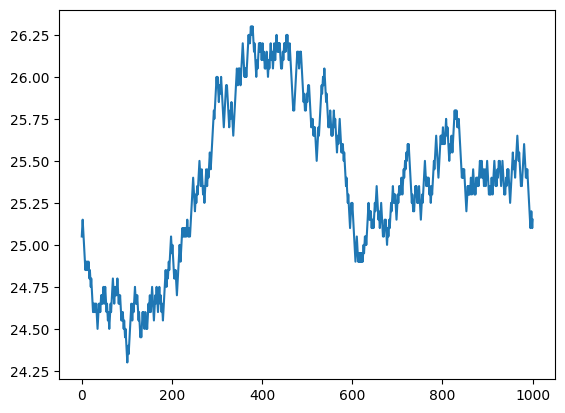

In [60]:
import matplotlib.pyplot as plt; data = []
for i, x in enumerate(Perlin(25, 5, 0.01)):
    if i > 1000: break
    data.append(x)
plt.plot(data);

In [274]:
#export
_structTypes = ["u8", "u16", "u32", "u64", "i16", "i32", "i64", "f32", "f64", "c"] # u8:1 for bit field, c:32 for char array of 32 bytes
_structLen   = {"u8": 8,   "u16": 16,  "u32": 32,  "u64": 64,  "i8": 8,   "i16": 16,  "i32": 32,  "i64": 64,  "f32": 32,  "f64": 64, "c": 1}
_structTrans = {"u8": "B", "u16": "H", "u32": "I", "u64": "Q", "i8": "b", "i16": "h", "i32": "i", "i64": "q", "f32": "f", "f64": "d"}
_byteMask = {1: 0b00000001, 2: 0b00000011, 3: 0b00000111, 4: 0b00001111, 5: 0b00011111, 6: 0b00111111, 7: 0b01111111, 8: 0b11111111}
class StructParseException(Exception): pass
class Struct:
    def __init__(self, structDef:dict):
        """Class to help with building structs in native python.
Vanilla example::

    s = k1.Struct({"a": "u8", "b": "u32", "c": "c:6"}) # 15.2 μs ± 2.85 μs, "c:6" means "char[6]"
    [s.a, s.b, s.c]                    # returns [0, 0, ""], no data in any fields
    s.a = 4; s.b = 5; s.c = "kirisame" # setting some fields
    raw = s | toBytes()                # 21.5 μs ± 3.12 μs, grabs raw bytes from the struct
    raw = s._toBytes()                 # 3.14 μs ± 221 ns, returns exactly the same as above, in case you don't want to use clis

    s = k1.Struct({"a": "u8", "b": "u32", "c": "c:6"}).parse(raw)   # 3.08 μs ± 385 ns, instantiates a new struct, then parses raw bytes
    [s.a, s.b, s.c]                    # returns [4, 5, b"kirisa", b'konpaku\\x00\\x00\\x00']

Hopefully this kinda makes sense to you. It's just a struct, afterall. You can
create a new struct from a definition dictionary, set its fields, then grab the
raw bytes. Then you can make a new struct, parses some raw bytes to set that
struct's fields. You can also see that for the strings, if the field is shorter,
then null characters will be padded, and if it's longer, then it will be truncated,
without null character at the end! There are these data types:

- Unsigned integers: u8, u16, u32, u64
- Signed integers: i8, i16, i32, i64
- Floating point: f32, f64
- String: c

This also supports bitfields, surprise! This was pretty hard to implement, but
it's pretty glorious::

    s = k1.Struct({"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4"})
    s.a = 1; s.d = 3; s.b = 5; s.c = 6; list(s | toBytes()) # returns [7, 5, 6]
    s = k1.Struct({"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4"}).parse(b'\\x07\\x05\\x06')
    [s.a, s.b, s.c, s.d] # returns [1, 5, 6, 3]

Finally, you can nest structs inside one another::

    sDef = {"a": "u8", "b": "u32", "c": "c:6", "d": {"a": "f32", "b": "f64"}}
    s = k1.Struct(sDef); s.d.a = 3.4; s.d.b = 0.1; s.c = "kirisame"
    raw = s | toBytes(); s = k1.Struct(sDef).parse(raw)
    [s.a, s.b, s.c, s.d.a, s.d.b] # returns [0, 0, b'kirisa', 3.4, 0.1]

This mechanism is also available on JS side, see :meth:`_js`"""
        self.structDef = structDef; self._s_vars = {}; groups = []; group = []; nbits = 0 # byte-aligned groups, number of bits in this group so far
        for name, _type in structDef.items():
            desc = ""
            if isinstance(_type, (str, tuple, list)): # typical regular types
                if isinstance(_type, tuple): _type, desc = _type
                res = _type.split(":"); typeRaw = res[0]; typeLen = int(res[1]) if len(res) > 1 else _structLen[typeRaw]
                if typeRaw not in _structTypes: raise StructParseException(f"Don't recognize type '{typeRaw}', has to be one of '{_structTypes}'")
                if typeRaw == "c":
                    if len(res) == 1: raise StructParseException(f"Character arrays/strings must have a length associated with it, like 'c:10', for char[10]")
                    self.__dict__[name] = ""; self._s_vars[name] = [typeRaw, typeLen*8, desc]
                    if nbits > 0: groups.append(group)
                    groups.append([name]); group = []; nbits = 0
                else:
                    if typeLen % 8 > 0 and typeRaw != "u8": raise StructParseException("Only u8 type is allowed to have bit field values")
                    self.__dict__[name] = 0; self._s_vars[name] = [typeRaw, typeLen, desc]
                    if typeLen <= 8-nbits: group.append(name); nbits += typeLen
                    else: groups.append(group); group = [name]; nbits = typeLen
            elif isinstance(_type, dict): # nested structs, expects a dict
                self.__dict__[name] = Struct(_type); self._s_vars[name] = [_type, len(self.__dict__[name])*8, desc]
                if group: groups.append(group)
                groups.append([name]); group = []
            else: raise StructParseException(f"Does not accept variable of type {type(_type)}. It has to either be a primitive type (u8, f32, etc) or a dict (nested struct)")
        groups.append(group); _vars = self._s_vars; a_groups = []; byteOffset = 0
        for group in groups:
            if len(group) == 0: continue
            bitField = any(_vars[name][1] < 8 for name in group); a_groups.append([bitField, byteOffset, group])
            if bitField: byteOffset += 1
            else: assert len(group) == 1; byteOffset += _vars[group[0]][1] // 8
        self._s_groups = a_groups; self._s_len = len(self._toBytes())
    def _s_valuesD(self): return {name: self.__dict__[name] for name in self._s_vars.keys()}
    def __str__(self): v = {x:str(y) if isinstance(y, Struct) else y for x,y in self._s_valuesD().items()}; return f"<Struct len={len(self)} values={v}>"
    def __repr__(self): v = {x:str(y) if isinstance(y, Struct) else y for x,y in self._s_valuesD().items()}; return f"<Struct len={len(self)} values={v}>\n  Raw: {self._s_vars}\n  Byte groups: {[g for bF,offset,g in self._s_groups]}"
    def __len__(self): return self._s_len
    def _toBytes(self):
        _vars = self._s_vars; values = self._s_valuesD(); ans = b""
        for bitField, byteOffset, group in self._s_groups:
            if bitField:
                value = 0; nbit = 0
                for name in group: typeRaw, typeLen, desc = _vars[name]; value += (values[name] & _byteMask[typeLen]) << nbit; nbit += typeLen
                ans += struct.pack("B", value)
            else:
                name = group[0]; typeRaw, typeLen, desc = _vars[name]
                if typeRaw == "c":
                    v = values[name]
                    if isinstance(v, str): v = v.encode()
                    if not isinstance(v, bytes): raise StructParseException(f"Variable '{name}' should be a string, but it's of type {type(v)} instead")
                    ans += (v + b"\0"*(typeLen//8-len(v)))[:typeLen//8]
                elif isinstance(typeRaw, str): ans += struct.pack(_structTrans[typeRaw], values[name])
                else: ans += values[name]._toBytes()
        return ans
    def parse(self, data:bytes):
        if len(self) != len(data): raise StructParseException("Length of input data does not match struct's length")
        _vars = self._s_vars; groupBounds = [*[x[1] for x in self._s_groups], len(self)]
        for i, [bitField, byteOffset, group] in enumerate(self._s_groups):
            localData = data[groupBounds[i]:groupBounds[i+1]]
            if bitField:
                assert len(localData) == 1; value = 0; nbit = 0; d = localData[0]
                for name in group: typeRaw, typeLen, desc = _vars[name]; self.__dict__[name] = d & _byteMask[typeLen]; d = d >> typeLen
            else:
                name = group[0]; typeRaw, typeLen, desc = _vars[name]
                if typeRaw == "c": self.__dict__[name] = localData
                elif isinstance(typeRaw, str): self.__dict__[name] = struct.unpack(_structTrans[typeRaw], localData)[0]
                else: self.__dict__[name].parse(localData)
        return self
    @staticmethod
    def _js():
        """JS source code to be able to build structs on the client side.
Example::

    let s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10"})
    s._d.a = 4; s._d.b = 5; s._d.c = "kirisame"; s._d.d = "konpaku" // have to use ._d instead of just setting the field, cause JS don't really have a __dict__ mechanism!
    let raw = s._toBytes() // returns Uint8Array

    s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10"}).parse(raw);
    s._d.a // returns 4
    s._d.c // returns "kirisa"
    s._d.d // returns "konpaku", trailing null characters have been eliminated

The above code is entirely in JS btw. See usage of this from Python to JS at :meth:`_toHtml`"""
        return """
_structTypes = ["u8", "u16", "u32", "u64", "i16", "i32", "i64", "f32", "f64", "c"] // u8:1 for bit field, c:32 for char array of 32 bytes
_structLen   = {"u8": 8,   "u16": 16,  "u32": 32,  "u64": 64,  "i8": 8,   "i16": 16,  "i32": 32,  "i64": 64,  "f32": 32,  "f64": 64, "c": 1}
_structTrans = {"u8": "B", "u16": "H", "u32": "I", "u64": "Q", "i8": "b", "i16": "h", "i32": "i", "i64": "q", "f32": "f", "f64": "d"}
_byteMask = {1:1,2:3,3:7,4:15,5:31,6:63,7:127,8:255}
function u8Eq(a,b){if(a.length!==b.length)return false;return a.every((v,i)=>v===b[i]);}
function Struct(structDef){ // pretty much copy-pasted from python, and changed a few things around to make it compatible with js
    let self={structDef,"_s_vars":{},"_d":{},"__len__":()=>self._s_len};self._toBytes=()=>Struct_toBytes(self);self.parse=(data)=>Struct_parse(self,data);
    let groups=[];let group=[];let nbits=0; // byte-aligned groups, number of bits in this group so far
    for (let [name, _type] of Object.entries(structDef)) { let desc = "";
        if (typeof _type === "string") { // typical regular types
            let res = _type.split(":"); let typeRaw = res[0]; let typeLen = res.length > 1 ? parseInt(res[1]) : _structLen[typeRaw];
            if (!_structTypes.includes(typeRaw)) throw new Error(`Don't recognize type '${typeRaw}', has to be one of '${_structTypes}'`);
            if (typeRaw === "c") { if (res.length == 1) throw new Error(`Character arrays/strings must have a length associated with it, like 'c:10', for char[10]`);
                self._d[name] = ""; self._s_vars[name] = [typeRaw, typeLen*8, desc]; if (nbits > 0) groups.push(group); groups.push([name]); group = []; nbits = 0;
            } else { if (typeLen % 8 > 0 && typeRaw != "u8") throw new Error("Only u8 type is allowed to have bit field values");
                self._d[name] = 0; self._s_vars[name] = [typeRaw, typeLen, desc]; if (typeLen <= 8-nbits) { group.push(name); nbits += typeLen; } else { groups.push(group); group = [name]; nbits = typeLen; } }
        } else { self._d[name] = Struct(_type); self._s_vars[name] = [_type, self._d[name].__len__()*8, desc]
            if (group.length > 0) groups.push(group); groups.push([name]); group = []; } // nested structs, expects a dict
    }; groups.push(group); let _vars = self._s_vars; let a_groups = []; let byteOffset = 0
    for (let group of groups) { if (group.length == 0) continue; let bitField = false; for (let name of group) if (_vars[name][1] < 8) bitField = true;
        a_groups.push([bitField, byteOffset, group]); if (bitField) byteOffset += 1; else byteOffset += Math.floor(_vars[group[0]][1] / 8);
    }; self._s_valuesD = () => { let d = {}; for (let name in self._s_vars) d[name] = self._d[name]; return d; }
    self._s_len = byteOffset; self._s_groups = a_groups; return self; }
function Struct_toBytes(struct) {
    let self = struct; let buffer = new ArrayBuffer(self.__len__()); let offset = 0; let ans = new DataView(buffer); let _vars = self._s_vars; let values = self._s_valuesD();
    for (let [bitField, byteOffset, group] of self._s_groups) {
        if (bitField) { let value = 0; let nbit = 0; for (let name of group) { let [typeRaw, typeLen, desc] = _vars[name]; value += (values[name] & _byteMask[typeLen]) << nbit; nbit += typeLen; }
            offset += struct_pack(ans, offset, "B", value);
        } else { let name = group[0]; let [typeRaw, typeLen, desc] = _vars[name]
            if (typeRaw === "c") { let encoded = (new TextEncoder()).encode(values[name]); let upper = Math.min(encoded.length, typeLen/8);
                for (let i = 0; i < upper; i++) ans.setUint8(offset + i, encoded[i]); for (let i = upper; i < typeLen/8; i++) ans.setUint8(offset + i, 0); offset += typeLen/8;
            } else if (typeof typeRaw === "string") { offset += struct_pack(ans, offset, _structTrans[typeRaw], values[name])
            } else { let sLen = values[name].__len__(); let sView = new DataView(values[name]._toBytes().buffer);
                for (let i = 0; i < sLen; i++) ans.setUint8(offset + i, sView.getUint8(i)); offset += sLen; }
        } }; return new Uint8Array(buffer); }
function Struct_parse(struct, data) {
    let self = struct; if (self.__len__() != data.length) throw new Error(`Length of input data (${data.length}) does not match struct's length (${self.__len__()})`);
    let _vars = self._s_vars; let groupBounds = [...self._s_groups.map((x) => x[1]), self.__len__()];
    for (let i = 0; i < self._s_groups.length; i++) {
        let [bitField, byteOffset, group] = self._s_groups[i]; let localData = data.subarray(groupBounds[i], groupBounds[i+1]);
        if (bitField) { let d = localData[0];
            for (let name of group) { let [typeRaw, typeLen, desc] = _vars[name]; self._d[name]=d & _byteMask[typeLen]; d = d >> typeLen; }
        } else { let name = group[0]; let [typeRaw, typeLen, desc] = _vars[name];
            if (typeRaw === "c") try { self._d[name] = new TextDecoder().decode(localData).replaceAll("\x00", ""); } catch (e) { self._d[name] = localData; }
            else if (typeof typeRaw === "string") self._d[name] = struct_unpack(localData, 0, _structTrans[typeRaw]);
            else self._d[name].parse(localData); }
    }; return self; }
function struct_pack(vw,o,format,v){switch(format){// kinda emulates python's struct.pack
case'b':vw.setInt8(o,v);return 1;case'B':vw.setUint8(o,v);return 1;case'h':vw.setInt16(o,v,true);return 2;case'H':vw.setUint16(o,v,true);return 2;
case'i':vw.setInt32(o,v,true);return 4;case'I':vw.setUint32(o,v,true);return 4;case'q':vw.setBigInt64(o,BigInt(v),true);return 8;case'Q':vw.setBigUint64(o,BigInt(v),true);return 8;
case'f':vw.setFloat32(o,v,true);return 4;case'd':vw.setFloat64(o,v,true);return 8;default:throw new Error(`Unknown format character: ${format[i]}`);};}
function struct_unpack(v,o,format){v=new DataView(v.buffer,v.byteOffset,v.byteLength);switch(format){
case'b':return v.getInt8(o);case'B':return v.getUint8(o);case'h':return v.getInt16(o,true);case'H':return v.getUint16(o,true);
case'i':return v.getInt32(o,true);case'I':return v.getUint32(o,true);case'q':return Number(v.getBigInt64(o,true));case'Q':return Number(v.getBigUint64(o,true));
case'f':return v.getFloat32(o,true);case'd':return v.getFloat64(o,true);default:throw new Error(`Unknown format character: ${format}`);};}"""
    @staticmethod
    def _styles(): return """<style>._s_row{display:flex;flex-direction: row;align-items:center;margin-bottom:8px;}._s_row>div:first-child{width:120px;}._s_row>input{width:150px;margin:0px 12px;}</style>"""
    @staticmethod # just put here cause I've spent time making the unit tests and lazy to store them at another place!
    def _jsTest(): return """
let s, ans, def; let assert = (x) => console.assert(x);
let assertClose = (x,y) => console.assert(Math.abs(x-y) < 1e-5);
def = {"a": "u8", "b": "u32", "c": "c:6", "d": "c:10"}; ans = new Uint8Array([4, 5, 0, 0, 0, 107, 105, 114, 105, 115, 97, 107, 111, 110, 112, 97, 107, 117, 0, 0, 0]);
s = Struct(def); s._d.a = 4; s._d.b = 5; s._d.c = "kirisame"; s._d.d = "konpaku"; assert(u8Eq(s._toBytes(), ans))
s = Struct(def).parse(ans); assert(s._d.a == 4); assert(s._d.b == 5); assert(s._d.c == "kirisa"); assert(s._d.d == "konpaku");
def = {"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4"}; ans = new Uint8Array([7, 5, 6]);
s = Struct(def); s._d.a = 1; s._d.d = 3.8; s._d.b = 5; s._d.c = 6; assert(u8Eq(s._toBytes(), ans))
s = Struct(def).parse(ans); assert(s._d.a == 1); assert(s._d.d == 3); assert(s._d.b == 5); assert(s._d.c == 6);
def = {"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4", "e": "u8:4"}; ans = new Uint8Array([7, 5, 70])
s = Struct(def); s._d.a = 1; s._d.d = 3; s._d.b = 5; s._d.c = 6; s._d.e = 4; assert(u8Eq(s._toBytes(), ans))
s = Struct(def).parse(ans); assert(s._d.a == 1); assert(s._d.d == 3); assert(s._d.b == 5); assert(s._d.c == 6); assert(s._d.e == 4);
def = {"a": "u8", "b": "u32", "c": "c:6", "d": {"a": "f32", "b": "f64"}}; ans = new Uint8Array([0, 0, 0, 0, 0, 107, 105, 114, 105, 115, 97, 154, 153, 89, 64, 154, 153, 153, 153, 153, 153, 185, 63]);
s = Struct(def); s._d.d._d.a = "3.4"; s._d.d._d.b = 0.1; s._d.c = "kirisame"; assert(u8Eq(s._toBytes(), ans));
s = Struct(def).parse(ans); assertClose(s._d.d._d.a, 3.4); assertClose(s._d.d._d.b, 0.1); assert(s._d.c == "kirisa");"""
    def _toHtml(self, pre=None): # grabs interface to modify
        """Creates a really nice html interface to change the struct's fields,
and provides callback functions to send the bytes to other places. Example::

    s = k1.Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10", "e": {"a": "f64", "b": "f32"}})
    s.e.a = 4.5; s.e.b = 6.8; s.a = 3; s.b = 345; s.c = "kirisame"; s.d = "konpaku"
    htm = s._toHtml("pre1"); header = f"{k1.Struct._styles()}<script>{k1.Struct._js()}</script>"
    (header + htm) | toHtml() # first time using the html, have to include k1.Struct._js(), and optionally include k1.Struct._styles() to make things prettier

    htm | toHtml() # after using it the first time, subsequent times don't have to include k1.Struct._js() or k1.Struct._styles()

The returned html contains input text boxes, as well as nice field annotations. Whenever you change any value
in the structs, you can grab the modified bytes on the JS side like this::

    let raw = pre1_obj.collate() // returns Uint8Array of the struct
    pre1_obj.update(raw)         // loads the struct and apply changes to the UI

This should allow you to easily send this to a server and have it deconstruct everything"""
        def _structNoDesc(s): return {k:(v[0] if isinstance(v, tuple) else (_structNoDesc(v) if isinstance(v, dict) else v)) for k,v in s.items()}
        h = ""; pre = pre or k1lib.cli.init._jsUIAuto(); values = self._s_valuesD(); nestedPres = {} # name -> pre
        for name, [typeRaw, typeLen, desc] in self._s_vars.items(): # what's up with the code smell in the generated html? Well, this generated html is intended to be served on an embedded environment, so has to be as small as possible!
            if isinstance(typeRaw, dict): _pre = k1lib.cli.init._jsUIAuto(); nestedPres[name] = _pre; h += f"<div style='margin-bottom:8px'>struct '{name}':</div><div style='margin-left:24px'>{values[name]._toHtml(_pre)}</div>"
            elif typeRaw[0] in "uifc": _type = "number" if typeRaw[0] in "uif" else "text"; h += f"<div class='_s_row'><div>{name}, {typeRaw}:{typeLen//8 if typeRaw == 'c' else typeLen}</div><input id='{pre}_{name}'class='{pre}_inps'type='{_type}'name='{name}'value='{values[name]}'/><div>{desc or '(no desc)'}</div></div>\n"
            else: raise Exception(f"Don't support type {typeRaw}")
        nO = ",".join([f"{name}: {_pre}_obj" for name, _pre in nestedPres.items()]) # nested objs
        return f"""{h}<script>window.{pre}_obj={{struct:Struct({_structNoDesc(self.structDef)}),nOs:{{{nO}}}}};(async()=>{{let o={pre}_obj;let dqA=(x)=>document.querySelectorAll(x);dqA(".{pre}_inps").forEach(x=>x.classList.add("input","input-bordered"));
o._re=()=>{{for(let n of Object.keys(o.nOs)){{o.nOs[n].struct=o.struct._d[n];o.nOs[n]._re();}}}};o._re();
o._cD=()=>{{return Object.fromEntries(Array.from(dqA(".{pre}_inps")).map((x)=>[x.name,x.value]));}};{'collateD' and ''}
o._uS=()=>{{for(let[n,_o]of Object.entries(o.nOs))_o._uS();{'update structs from real values' and ''}let d=o._cD();for(let[n,v]of Object.entries(d))o.struct._d[n]=v;}};
o.collate=()=>{{o._uS();return o.struct._toBytes();}};
o._ui=()=>{{for(let [n,a]of Object.entries(o.struct._s_vars)) if(typeof(a[0])==="string"){{ document.querySelector(`#{pre}_${{n}}`).value=o.struct._d[n]; document.querySelector(`#{pre}_${{n}}`).value=document.querySelector(`#{pre}_${{n}}`).value.replaceAll("\\x00", ""); }}else o.nOs[n]._ui();}};{'updateUI' and ''}
o.update=(b)=>{{o.struct.parse(b);o._ui();}};o.update(new Uint8Array([{','.join([str(x) for x in self._toBytes()])}]));}})();</script>"""

In [275]:
s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10", "e": {"a": "f64", "b": "f32"}})
s.e.a = 4.5; s.e.b = 6.8; s.a = 3; s.b = 345; s.c = "kirisame"; s.d = "konpaku1"

In [276]:
s._toBytes()

b'\x03Y\x01\x00\x00kirisakonpaku1\x00\x00\x00\x00\x00\x00\x00\x00\x12@\x9a\x99\xd9@'

In [269]:
SStrDef = {"wifiUser": ("c:30", "Wifi user to connect to internet"), "wifiPass": ("c:30", "Wifi password to connect to internet"), "apPass": ("c:30", "Wifi password for the generated Access Point"), "dhcpServer": ("c:30", "Backend server to communicate with, for horizontal scaling later on"), "reserved": ("c:80", "extra bytes to reserve space for future editions")}

In [270]:
s = Struct(SStrDef); s.wifiUser = "Ngoc Anh"; s.wifiPass = "3840197"

In [265]:
s.parse(s._toBytes())

<Struct len=200 values={'wifiUser': b'Ngoc Anh\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'wifiPass': b'3840197\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'apPass': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'dhcpServer': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'reserved': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'}>
  Raw: {'wifiUser': ['c', 240, 'Wifi user to connect to internet'], 'wifiPass': ['c', 240, 'Wifi password to connect to internet'], 'ap

In [271]:
f"{Struct._styles()}<script>{Struct._js()}</script>{s._toHtml("p6")}" | k1lib.cli.toHtml()

'<style>._s_row{display:flex;flex-direction: row;align-items:center;margin-bottom:8px;}._s_row>div:first-child{width:120px;}._s_row>input{width:150px;margin:0px 12px;}</style><script>\n_structTypes = ["u8", "u16", "u32", "u64", "i16", "i32", "i64", "f32", "f64", "c"] // u8:1 for bit field, c:32 for char array of 32 bytes\n_structLen   = {"u8": 8,   "u16": 16,  "u32": 32,  "u64": 64,  "i8": 8,   "i16": 16,  "i32": 32,  "i64": 64,  "f32": 32,  "f64": 64, "c": 1}\n_structTrans = {"u8": "B", "u16": "H", "u32": "I", "u64": "Q", "i8": "b", "i16": "h", "i32": "i", "i64": "q", "f32": "f", "f64": "d"}\n_byteMask = {1:1,2:3,3:7,4:15,5:31,6:63,7:127,8:255}\nfunction u8Eq(a,b){if(a.length!==b.length)return false;return a.every((v,i)=>v===b[i]);}\nfunction Struct(structDef){ // pretty much copy-pasted from python, and changed a few things around to make it compatible with js\n    let self={structDef,"_s_vars":{},"_d":{},"__len__":()=>self._s_len};self._toBytes=()=>Struct_toBytes(self);self.parse=(data)=>Struct_parse(self,data);\n    let groups=[];let group=[];let nbits=0; // byte-aligned groups, number of bits in this group so far\n    for (let [name, _type] of Object.entries(structDef)) { let desc = "";\n        if (typeof _type === "string") { // typical regular types\n            let res = _type.split(":"); let typeRaw = res[0]; let typeLen = res.length > 1 ? parseInt(res[1]) : _structLen[typeRaw];\n            if (!_structTypes.includes(typeRaw)) throw new Error(`Don\'t recognize type \'${typeRaw}\', has to be one of \'${_structTypes}\'`);\n            if (typeRaw === "c") { if (res.length == 1) throw new Error(`Character arrays/strings must have a length associated with it, like \'c:10\', for char[10]`);\n                self._d[name] = ""; self._s_vars[name] = [typeRaw, typeLen*8, desc]; if (nbits > 0) groups.push(group); groups.push([name]); group = []; nbits = 0;\n            } else { if (typeLen % 8 > 0 && typeRaw != "u8") throw new Error("Only u8 type is allowed to have bit field values");\n                self._d[name] = 0; self._s_vars[name] = [typeRaw, typeLen, desc]; if (typeLen <= 8-nbits) { group.push(name); nbits += typeLen; } else { groups.push(group); group = [name]; nbits = typeLen; } }\n        } else { self._d[name] = Struct(_type); self._s_vars[name] = [_type, self._d[name].__len__()*8, desc]\n            if (group.length > 0) groups.push(group); groups.push([name]); group = []; } // nested structs, expects a dict\n    }; groups.push(group); let _vars = self._s_vars; let a_groups = []; let byteOffset = 0\n    for (let group of groups) { if (group.length == 0) continue; let bitField = false; for (let name of group) if (_vars[name][1] < 8) bitField = true;\n        a_groups.push([bitField, byteOffset, group]); if (bitField) byteOffset += 1; else byteOffset += Math.floor(_vars[group[0]][1] / 8);\n    }; self._s_valuesD = () => { let d = {}; for (let name in self._s_vars) d[name] = self._d[name]; return d; }\n    self._s_len = byteOffset; self._s_groups = a_groups; return self; }\nfunction Struct_toBytes(struct) {\n    let self = struct; let buffer = new ArrayBuffer(self.__len__()); let offset = 0; let ans = new DataView(buffer); let _vars = self._s_vars; let values = self._s_valuesD();\n    for (let [bitField, byteOffset, group] of self._s_groups) {\n        if (bitField) { let value = 0; let nbit = 0; for (let name of group) { let [typeRaw, typeLen, desc] = _vars[name]; value += (values[name] & _byteMask[typeLen]) << nbit; nbit += typeLen; }\n            offset += struct_pack(ans, offset, "B", value);\n        } else { let name = group[0]; let [typeRaw, typeLen, desc] = _vars[name]\n            if (typeRaw === "c") { let encoded = (new TextEncoder()).encode(values[name]); let upper = Math.min(encoded.length, typeLen/8);\n                for (let i = 0; i < upper; i++) ans.setUint8(offset + i, encoded[i]); for (let i = upper; i < typeLen/8; i++) ans.setUint8(offset + i, 0); offset += typeLen/8;\n            } else if (t

In [232]:
s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10", "e": {"a": "f64", "b": "f32"}})
s.e.a = 4.5; s.e.b = 6.8; s.a = 3; s.b = 345; s.c = "kirisame"; s.d = "konpaku1"

In [233]:
print(s._toHtml("pre1"))

<div class='_s_row'><div>a, u8:8</div><input id='pre1_a'class='pre1_inps'type='number'name='a'value='3'/><div>(no desc)</div></div>
<div class='_s_row'><div>b, u32:32</div><input id='pre1_b'class='pre1_inps'type='number'name='b'value='345'/><div>(no desc)</div></div>
<div class='_s_row'><div>c, c:48</div><input id='pre1_c'class='pre1_inps'type='text'name='c'value='kirisame'/><div>(no desc)</div></div>
<div class='_s_row'><div>d, c:80</div><input id='pre1_d'class='pre1_inps'type='text'name='d'value='konpaku1'/><div>(no desc)</div></div>
<div style='margin-bottom:8px'>struct 'e':</div><div style='margin-left:24px'><div class='_s_row'><div>a, f64:64</div><input id='_jsUI_23_a'class='_jsUI_23_inps'type='number'name='a'value='4.5'/><div>(no desc)</div></div>
<div class='_s_row'><div>b, f32:32</div><input id='_jsUI_23_b'class='_jsUI_23_inps'type='number'name='b'value='6.8'/><div>(no desc)</div></div>
<script>window._jsUI_23_obj={struct:Struct({'a': 'f64', 'b': 'f32'}),nOs:{}};(async()=>{let 

In [268]:
s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10", "e": {"a": "f64", "b": "f32"}})
s.e.a = 4.5; s.e.b = 6.8; s.a = 3; s.b = 345; s.c = "kirisame"; s.d = "konpaku1"
s = s._toHtml("pre1"); (f"{Struct._styles()}<script>{Struct._js()}</script>" + s) | k1lib.cli.toHtml()

'<style>._s_row{display:flex;flex-direction: row;align-items:center;margin-bottom:8px;}._s_row>div:first-child{width:120px;}._s_row>input{width:150px;margin:0px 12px;}</style><script>\n_structTypes = ["u8", "u16", "u32", "u64", "i16", "i32", "i64", "f32", "f64", "c"] // u8:1 for bit field, c:32 for char array of 32 bytes\n_structLen   = {"u8": 8,   "u16": 16,  "u32": 32,  "u64": 64,  "i8": 8,   "i16": 16,  "i32": 32,  "i64": 64,  "f32": 32,  "f64": 64, "c": 1}\n_structTrans = {"u8": "B", "u16": "H", "u32": "I", "u64": "Q", "i8": "b", "i16": "h", "i32": "i", "i64": "q", "f32": "f", "f64": "d"}\n_byteMask = {1:1,2:3,3:7,4:15,5:31,6:63,7:127,8:255}\nfunction u8Eq(a,b){if(a.length!==b.length)return false;return a.every((v,i)=>v===b[i]);}\nfunction Struct(structDef){ // pretty much copy-pasted from python, and changed a few things around to make it compatible with js\n    let self={structDef,"_s_vars":{},"_d":{},"__len__":()=>self._s_len};self._toBytes=()=>Struct_toBytes(self);self.parse=(data)=>Struct_parse(self,data);\n    let groups=[];let group=[];let nbits=0; // byte-aligned groups, number of bits in this group so far\n    for (let [name, _type] of Object.entries(structDef)) { let desc = "";\n        if (typeof _type === "string") { // typical regular types\n            let res = _type.split(":"); let typeRaw = res[0]; let typeLen = res.length > 1 ? parseInt(res[1]) : _structLen[typeRaw];\n            if (!_structTypes.includes(typeRaw)) throw new Error(`Don\'t recognize type \'${typeRaw}\', has to be one of \'${_structTypes}\'`);\n            if (typeRaw === "c") { if (res.length == 1) throw new Error(`Character arrays/strings must have a length associated with it, like \'c:10\', for char[10]`);\n                self._d[name] = ""; self._s_vars[name] = [typeRaw, typeLen*8, desc]; if (nbits > 0) groups.push(group); groups.push([name]); group = []; nbits = 0;\n            } else { if (typeLen % 8 > 0 && typeRaw != "u8") throw new Error("Only u8 type is allowed to have bit field values");\n                self._d[name] = 0; self._s_vars[name] = [typeRaw, typeLen, desc]; if (typeLen <= 8-nbits) { group.push(name); nbits += typeLen; } else { groups.push(group); group = [name]; nbits = typeLen; } }\n        } else { self._d[name] = Struct(_type); self._s_vars[name] = [_type, self._d[name].__len__()*8, desc]\n            if (group.length > 0) groups.push(group); groups.push([name]); group = []; } // nested structs, expects a dict\n    }; groups.push(group); let _vars = self._s_vars; let a_groups = []; let byteOffset = 0\n    for (let group of groups) { if (group.length == 0) continue; let bitField = false; for (let name of group) if (_vars[name][1] < 8) bitField = true;\n        a_groups.push([bitField, byteOffset, group]); if (bitField) byteOffset += 1; else byteOffset += Math.floor(_vars[group[0]][1] / 8);\n    }; self._s_valuesD = () => { let d = {}; for (let name in self._s_vars) d[name] = self._d[name]; return d; }\n    self._s_len = byteOffset; self._s_groups = a_groups; return self; }\nfunction Struct_toBytes(struct) {\n    let self = struct; let buffer = new ArrayBuffer(self.__len__()); let offset = 0; let ans = new DataView(buffer); let _vars = self._s_vars; let values = self._s_valuesD();\n    for (let [bitField, byteOffset, group] of self._s_groups) {\n        if (bitField) { let value = 0; let nbit = 0; for (let name of group) { let [typeRaw, typeLen, desc] = _vars[name]; value += (values[name] & _byteMask[typeLen]) << nbit; nbit += typeLen; }\n            offset += struct_pack(ans, offset, "B", value);\n        } else { let name = group[0]; let [typeRaw, typeLen, desc] = _vars[name]\n            if (typeRaw === "c") { let encoded = (new TextEncoder()).encode(values[name]); let upper = Math.min(encoded.length, typeLen/8);\n                for (let i = 0; i < upper; i++) ans.setUint8(offset + i, encoded[i]); for (let i = upper; i < typeLen/8; i++) ans.setUint8(offset + i, 0); offset += typeLen/8;\n            } else if (t

In [11]:
s = Struct({"a": "u8:3", "b": "u8:4", "c": "c:6", "d": "c:10", "e": {"a": "f64", "b": "f32"}})
s.e.a = 4.5; s.e.b = 6.8; s.a = 3; s.b = 4634; s.c = "kirisame"; s.d = "konpaku"
h = s._toHtml("pre6"); (f"<script>{Struct._js()}</script>{h}") | k1lib.cli.toHtml()

'<script>\n_structTypes = ["u8", "u16", "u32", "u64", "i16", "i32", "i64", "f32", "f64", "c"] // u8:1 for bit field, c:32 for char array of 32 bytes\n_structLen   = {"u8": 8,   "u16": 16,  "u32": 32,  "u64": 64,  "i8": 8,   "i16": 16,  "i32": 32,  "i64": 64,  "f32": 32,  "f64": 64, "c": 1}\n_structTrans = {"u8": "B", "u16": "H", "u32": "I", "u64": "Q", "i8": "b", "i16": "h", "i32": "i", "i64": "q", "f32": "f", "f64": "d"}\n_byteMask = {1: 1, 2: 3, 3: 7, 4: 15, 5: 31, 6: 63, 7: 127, 8: 255}\nfunction u8Eq(a, b) { if (a.length !== b.length) return false; return a.every((val, index) => val === b[index]); }\nfunction Struct(structDef) { // pretty much copy-pasted from python, and changed a few things around to make it compatible with js\n    let self = {structDef, "_s_vars": {}, "__dict__": {}, "__len__": () => self._s_len}; self._d = self.__dict__; self._toBytes = () => Struct_toBytes(self); self.parse = (data) => Struct_parse(self, data);\n    let groups = []; let group = []; let nbits = 0; // byte-aligned groups, number of bits in this group so far\n    for (let [name, _type] of Object.entries(structDef)) { let desc = "";\n        if (typeof _type === "string") { // typical regular types\n            let res = _type.split(":"); let typeRaw = res[0]; let typeLen = res.length > 1 ? parseInt(res[1]) : _structLen[typeRaw];\n            if (!_structTypes.includes(typeRaw)) throw new Error(`Don\'t recognize type \'${typeRaw}\', has to be one of \'${_structTypes}\'`);\n            if (typeRaw === "c") { if (res.length == 1) throw new Error(`Character arrays/strings must have a length associated with it, like \'c:10\', for char[10]`);\n                self.__dict__[name] = ""; self._s_vars[name] = [typeRaw, typeLen*8, desc]; if (nbits > 0) groups.push(group); groups.push([name]); group = []; nbits = 0;\n            } else { if (typeLen % 8 > 0 && typeRaw != "u8") throw new Error("Only u8 type is allowed to have bit field values");\n                self.__dict__[name] = 0; self._s_vars[name] = [typeRaw, typeLen, desc]; if (typeLen <= 8-nbits) { group.push(name); nbits += typeLen; } else { groups.push(group); group = [name]; nbits = typeLen; } }\n        } else { self.__dict__[name] = Struct(_type); self._s_vars[name] = [_type, self.__dict__[name].__len__()*8, desc]\n            if (group.length > 0) groups.push(group); groups.push([name]); group = []; } // nested structs, expects a dict\n    }; groups.push(group); let _vars = self._s_vars; let a_groups = []; let byteOffset = 0\n    for (let group of groups) { if (group.length == 0) continue; let bitField = false; for (let name of group) if (_vars[name][1] < 8) bitField = true;\n        a_groups.push([bitField, byteOffset, group]); if (bitField) byteOffset += 1; else byteOffset += Math.floor(_vars[group[0]][1] / 8);\n    }; self._s_valuesD = () => { let d = {}; for (let name in self._s_vars) d[name] = self.__dict__[name]; return d; }\n    self._s_len = byteOffset; self._s_groups = a_groups; return self; }\nfunction Struct_toBytes(struct) {\n    let self = struct; let buffer = new ArrayBuffer(self.__len__()); let offset = 0; let ans = new DataView(buffer); let _vars = self._s_vars; let values = self._s_valuesD();\n    for (let [bitField, byteOffset, group] of self._s_groups) {\n        if (bitField) { let value = 0; let nbit = 0; for (let name of group) { let [typeRaw, typeLen, desc] = _vars[name]; value += (values[name] & _byteMask[typeLen]) << nbit; nbit += typeLen; }\n            offset += struct_pack(ans, offset, "B", value);\n        } else { let name = group[0]; let [typeRaw, typeLen, desc] = _vars[name]\n            if (typeRaw === "c") { let encoded = (new TextEncoder()).encode(values[name]); let upper = Math.min(encoded.length, typeLen/8);\n                for (let i = 0; i < upper; i++) ans.setUint8(offset + i, encoded[i]); for (let i = upper; i < typeLen/8; i++) ans.setUint8(offset + i, 0); offset += typeLen/8;\n            } else if (typeof typeRaw === "string") { offset += st

In [13]:
try: Struct({"a": "u8:4", "b": "u32", "c": "c:6", "d": 3}); assert False
except StructParseException as e: pass
try: Struct({"a": "u8:4", "b": "u32:3", "c": "c:6", "d": "c:10"}); assert False
except StructParseException as e: pass

s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10"})
s.a = 4; s.b = 5; s.c = "kirisame"; s.d = "konpaku"; assert s._toBytes() == b'\x04\x05\x00\x00\x00kirisakonpaku\x00\x00\x00'
s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": "c:10"}).parse(b'\x04\x05\x00\x00\x00kirisakonpaku\x00\x00\x00')
assert [s.a, s.b, s.c, s.d] == [4, 5, b"kirisa", b'konpaku\x00\x00\x00']; s

s = Struct({"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4"})
s.a = 1; s.d = 3; s.b = 5; s.c = 6; assert list(s._toBytes()) == [7, 5, 6]
s = Struct({"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4"}).parse(b'\x07\x05\x06')
assert [s.a, s.b, s.c, s.d] == [1, 5, 6, 3]; s

s = Struct({"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4", "e": "u8:4"})
s.a = 1; s.d = 3; s.b = 5; s.c = 6; s.e = 4; assert s._toBytes() == b'\x07\x05F'
s = Struct({"a": "u8:1", "d": "u8:5", "b": "u8", "c": "u8:4", "e": "u8:4"}).parse(b'\x07\x05F')
assert [s.a, s.b, s.c, s.d, s.e] == [1, 5, 6, 3, 4]; s

s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": {"a": "f32", "b": "f64"}}); s.d.a = 3.4; s.d.b = 0.1; s.c = "kirisame"
assert s._toBytes() == b'\x00\x00\x00\x00\x00kirisa\x9a\x99Y@\x9a\x99\x99\x99\x99\x99\xb9?'; s
s = Struct({"a": "u8", "b": "u32", "c": "c:6", "d": {"a": "f32", "b": "f64"}}).parse(b'\x00\x00\x00\x00\x00kirisa\x9a\x99Y@\x9a\x99\x99\x99\x99\x99\xb9?')
assert [s.a, s.b, s.c] == [0, 0, b'kirisa']; assert abs(s.d.a - 3.4) < 1e-6; assert abs(s.d.b - 0.1) < 1e-6; s

<Struct len=23 values={'a': 0, 'b': 0, 'c': b'kirisa', 'd': "<Struct len=12 values={'a': 3.4000000953674316, 'b': 0.1}>"}>
  Raw: {'a': ['u8', 8, ''], 'b': ['u32', 32, ''], 'c': ['c', 48, ''], 'd': [{'a': 'f32', 'b': 'f64'}, 96, '']}
  Byte groups: [['a'], ['b'], ['c'], ['d']]

In [272]:
!../export.py _baseClasses --upload=True

./export started up - /home/quang/miniforge3/bin/python
----- exportAll
16977   0   60%   
11244   1   40%   
installing...
Found existing installation: k1lib 1.8
Uninstalling k1lib-1.8:
  Successfully uninstalled k1lib-1.8
DEPRECATION: Loading egg at /home/quang/miniforge3/lib/python3.12/site-packages/aigu-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, http://10.104.0.3:3141/
Processing /home/quang/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.8-py3-none-any.whl size=5143460 sha256=b84fa279b55a03c72e0a3f8dcafd6e56cd639eeb230312211ffb879983987ad7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1o1f174u/wheels/b5/32/67/e20c84dce16d707fb881c12d405f70adfaa36fe7dae9021380
Successfully built k1lib
installed
uploading...
uploaded


In [48]:
!../export.py _baseClasses --bootstrap=True

./export started up - /home/quang/miniforge3/bin/python
----- bootstrapping
Current dir: /home/quang/k1lib, /home/quang/k1lib/k1lib/../export.py
Found existing installation: k1lib 1.7
Uninstalling k1lib-1.7:
  Successfully uninstalled k1lib-1.7
DEPRECATION: Loading egg at /home/quang/miniforge3/lib/python3.12/site-packages/aigu-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, http://10.104.0.3:3141/
Processing /home/quang/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.7-py3-none-any.whl size=5107710 sha256=d5382476821b4969f8c3f5e56df4b589fbb0638c35d5aa07536b52a82e81dd6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-hdpkr_jv/wheels/b5/32/67/e20c84dce16d707fb881c12d405f70adfaa36fe7dae9021380
Successfully built k1lib
